# use VAE to generate word embedding

the input sample is the PMI signature of the word

## 1. Imports and Helper Functions

In [153]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix
import scipy.spatial.distance as dist
import scipy.stats as stats
from functools import reduce
import math
from collections import defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from gensim.models.keyedvectors import KeyedVectors
slim=tf.contrib.slim
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [27]:
%matplotlib inline

In [7]:
%matplotlib notebook

In [8]:
plt.rcParams["figure.figsize"] = (5, 3)

In [9]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

In [10]:
class Vocab(object):
    def __init__(self):
        self.BOS = '<s>'
        self.EOS = '</s>'
        self.UNK = '<unk>'
        self.ngram = [1]

    def build_from_files(self, train_files, test_files=[]):
        if type(train_files) is not list or type(test_files) is not list:
            raise ValueError('build_from_files input type error')

        print("build vocabulary from files ...")
        self.word_cnt = {self.EOS: 0, self.UNK: 0}
        self.char_cnt = {self.EOS: 0, self.UNK: 0}
        self.word_size = 1
        self.train_word = set()
        for _tag, _file in list(map(lambda f: ('train', f), train_files)) + list(map(lambda f: ('test', f), test_files)):
            line_num = 0
            for line in open(_file):
                line_num += 1
                for w in line.strip().split():
                    if _tag == 'train':
                        self.train_word.add(w)
                    if w in self.word_cnt:
                        self.word_cnt[w] += 1
                    else:
                        self.word_cnt[w] = 1
                    if w == self.UNK:
                        self.char_cnt[w] += 1
                    else:
                        self.word_size = max(self.word_size, len(w))
                        for c in list(w):
                            if c not in self.char_cnt:
                                self.char_cnt[c] = 1
                            else:
                                self.char_cnt[c] += 1
            if line_num > 0 and _tag == 'train':
                self.train_word.add(self.EOS)
            self.word_cnt[self.EOS] += line_num
            self.char_cnt[self.EOS] += line_num
        word_count_pairs = sorted(self.word_cnt.items(), key=lambda x: (-x[1], x[0]))
        self.words, _ = list(zip(*word_count_pairs))
        char_count_pairs = sorted(self.char_cnt.items(), key=lambda x: (-x[1], x[0]))
        self.chars, _ = list(zip(*char_count_pairs))

        self.word2id = dict(zip(self.words, range(len(self.words))))
        self.char2id = dict(zip(self.chars, range(len(self.chars))))
        self.UNK_ID = self.word2id[self.UNK]
        print('vocab size: {}, train vocab size: {}, OOV size: {}'.format(
            self.size(), len(self.train_word), self.size() - len(self.train_word)))
        print('char size: {} with max length {}'.format(self.char_size(), self.word_size))

        self.pre_emb = self.build_pre_emb(ngram=self.ngram)
        print('pre emb size with ngram {}: {}'.format(self.ngram, self.pre_emb.shape[1]))

    def build_pre_emb(self, ngram=[3]):
        def split_by_ngram(w, valid=None, ngram=[3]):
            sens = []
            for ng in ngram:
                if w == self.BOS or w == self.EOS:
                    return '#END_NGRAM'
                if w == self.UNK:
                    return '#UNKNOWN_NGRAM'
                ws = list('#' + w + '#')
                sen = ' '.join([''.join(ws[i:i+ng]) if not valid or ''.join(ws[i:i+ng]) in valid else '#UNKNOWN_NGRAM'
                                for i in range(max(len(ws) - ng + 1, 1))])
                sens.append(sen)
            return ' '.join(sens)
        valid_ngram = [split_by_ngram(w, ngram=ngram) for w in self.train_word]
        valid_ngram = reduce(lambda t,x: t | set(x.split()), valid_ngram, set())
        ngram = [split_by_ngram(w, valid=valid_ngram, ngram=ngram) for w in self.words]
        vectorizer = CountVectorizer(min_df=1, binary=True, token_pattern=r'\b[\S]+\b')
        return vectorizer.fit_transform(ngram).toarray().astype(np.float32)

    def encode(self, sentence):
        if type(sentence) is not list:
            w = sentence
            return self.word2id[w] if w in self.word2id else self.UNK_ID
        return [self.word2id[w] if w in self.word2id else self.UNK_ID for w in sentence]

    def decode(self, ids):
        if type(ids) is not list:
            _id = ids
            return self.words[_id]
        return [self.words[_id] for _id in ids]

    def encode_word(self, word):
        result = [0] * self.word_size
        if word == self.UNK or word == self.EOS:
            result[0] = self.char2id[word]
            length = 1
        else:
            length = len(word)
            for i in range(length):
                result[i] = self.char2id[word[i]] \
                    if word[i] in self.char2id else self.char2id[self.UNK]
        return result, length

    def decode_word(self, ids):
        return ''.join([self.chars[_id] for _id in ids])

    def size(self):
        return len(self.words)

    def char_size(self):
        return len(self.chars)

    def word2id(self):
        return self.word2id

In [11]:
def save_emb(emb, vocab, filename):
    with open(filename, 'w') as fp:
        fp.write('{} {}\n'.format(vocab.size(), emb.shape[1]))
        for i in range(vocab.size()):
            fp.write('{} {}\n'.format(vocab.decode(i), 
                                     ' '.join(str(v) for v in emb[i])))

In [12]:
def generate_word_doc(text_file, vocab, stopwords={}, window_size=3, min_count=5):
    docs = []
    with open(text_file, 'r') as fp:
        for line in fp:
            sen = line.strip().split() + [vocab.EOS]
            docs.append([w for w in sen if w not in stopwords])
    finder = BigramCollocationFinder.from_words(
        BigramCollocationFinder._build_new_documents(
            docs, window_size, pad_right=True), window_size=window_size)
    docs = {}
    for word in vocab.word_cnt:
        if word in {'</s>'}:
            continue
        if vocab.word_cnt[word] >= min_count:
            docs[word] = defaultdict(lambda: 0)
    for bigram in finder.ngram_fd:
        if bigram[0] not in docs or bigram[1] not in docs:
            continue
        docs[bigram[0]][bigram[1]] += finder.ngram_fd[bigram]
        docs[bigram[1]][bigram[0]] += finder.ngram_fd[bigram]
    for word in list(docs.keys()):
        if len(docs[word]) <= 0:
            del docs[word]
    print('total {} docs'.format(len(docs)))
    return docs
def output_word_doc(word_docs, filename, is_gibbslda=False):
    with open(filename, 'w') as fp:
        if is_gibbslda:
            fp.write('{}\n'.format(len(word_docs)))
        for word in word_docs:
            if not is_gibbslda:
                fp.write('{}'.format(word))
            for context in word_docs[word]:
                if word_docs[word][context] > 0:
                    fp.write(('' if is_gibbslda else ' ') + 
                             '{}'.format(' '.join([context] * word_docs[word][context])))
            fp.write('\n')

## 2. Load Data

In [13]:
text_file = '../WER/ptb_data/train.txt'
#text_file = '../word2vec/data/text8'
#text_file = '../Tensorflow-101/notebooks/data/text8_50000'
wordsim_file = '../wordsim_eval/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt'

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['<unk>', '</s>', 'mr.', "'s", 'N']
stopwords = set(stopwords)

In [15]:
vocab = Vocab()
vocab.build_from_files(train_files=[text_file])

build vocabulary from files ...
vocab size: 10000, train vocab size: 10000, OOV size: 0
char size: 48 with max length 19
pre emb size with ngram [1]: 38


In [16]:
word_docs = generate_word_doc(text_file, vocab, stopwords={}, window_size=4, min_count=5)
output_word_doc(word_docs, 'ptb_word_docs.txt')
output_word_doc(word_docs, 'ptb_word_docs_gibbslda.txt', is_gibbslda=True)

total 9857 docs


In [17]:
def load_wordsim(filename, vocab=None):
    r = []
    with open(filename, 'r') as fp:
        for l in fp:
            w1, w2, s = l.split()
            if vocab != None and w1 in vocab and w2 in vocab:
                r.append((w1, w2, float(s)))
    return sorted(r, key=lambda x:-x[2])

In [18]:
wordsim = load_wordsim(wordsim_file, vocab=vocab.word2id)
print('test wordsim pair count: %d' % len(wordsim))

test wordsim pair count: 131


In [19]:
def get_real_pmi(real_co_count, rescale=False):
    bigram_dict = {}
    unigram_dict = {}
    total_N = 0
    for bi, bi_count in real_co_count:
        bi_count = math.sqrt(bi_count) if rescale else bi_count
        if bi in bigram_dict:
            bigram_dict[bi] += bi_count
        elif (bi[1], bi[0]) in bigram_dict:
            bigram_dict[(bi[1], bi[0])] += bi_count
        else:
            bigram_dict[bi] = bi_count
        if bi[0] not in unigram_dict:
            unigram_dict[bi[0]] = 0
        if bi[1] not in unigram_dict:
            unigram_dict[bi[1]] = 0
        unigram_dict[bi[0]] += bi_count
        unigram_dict[bi[1]] += bi_count
        total_N += 2 * bi_count       
    pmi = [(bi, math.log(bi_count * total_N / (unigram_dict[bi[0]] * unigram_dict[bi[1]])))
           for bi,bi_count in bigram_dict.items()]
    co_count = [(bi, bi_count) for bi,bi_count in bigram_dict.items()]
    return pmi, co_count
def pmi_from_text(text_file, vocab, stopwords={}, min_count=5, window_size=5, real=True, rescale=False):
    docs = []
    with open(text_file, 'r') as fp:
        for line in fp:
            sen = line.strip().split() + [vocab.EOS]
            #sen2id = vocab.encode(sen)
            docs.append([w for w in sen if w not in stopwords])
    finder = BigramCollocationFinder.from_words(
        BigramCollocationFinder._build_new_documents(
            docs, window_size, pad_right=True), window_size=window_size)
    print('build finder over')
    finder.apply_freq_filter(min_count)
    bigram_measures = BigramAssocMeasures()
    pmi = finder.score_ngrams(bigram_measures.pmi)
    print('finder score standard pmi')
    co_count = finder.score_ngrams(lambda a,b,c: a)
    print('finder score fake cocount')
    real_co_count = finder.score_ngrams(lambda a,b,c: a * (window_size - 1))
    print('finder score real cocount')
    real_pmi, real_co_count = get_real_pmi(real_co_count, rescale=rescale)
    if real:
        return real_pmi, real_co_count, finder
    return pmi, co_count, finder
def build_pmi_matrix(pmi, vocab, binary=False, 
                     weighted_matrix_factorization=False,
                     negative_sample=1):
    row = [vocab.encode(it[0][0]) for it in pmi]
    col = [vocab.encode(it[0][1]) for it in pmi]
    data = [((math.exp(it[1]) / (math.exp(it[1]) + negative_sample))
             if weighted_matrix_factorization else 1.0)
            if binary else it[1] for it in pmi]
    nrow = row + col
    ncol = col + row
    ndata = data + data
    unrow, uncol, undata = [], [], []
    uni = set()
    for i in range(len(nrow)):
        if (nrow[i], ncol[i]) not in uni:
            uni.add((nrow[i], ncol[i]))
            unrow.append(nrow[i])
            uncol.append(ncol[i])
            undata.append(ndata[i])  
    #aa, bb = list(zip(*(list(set(list(zip(nrow, ncol)))))))
    #nrow, ncol, ndata = list(zip(*(list(set(list(zip(nrow, ncol, ndata)))))))
    matrix = csr_matrix((undata, (unrow, uncol)), 
                        shape=(vocab.size(), vocab.size()))
    return matrix

In [20]:
BINARY = True
N_COMPONENTS = 100
USE_SVD = False
WMF = True
NS = 100

In [21]:
pmi, co_count, finder = pmi_from_text(text_file, vocab, stopwords={}, 
                    min_count=1, window_size=3, real=True, rescale=False)
print('build pmi over')
matrix = build_pmi_matrix(pmi, vocab, binary=BINARY,
                          weighted_matrix_factorization=WMF, negative_sample=NS)
co_matrix = build_pmi_matrix(co_count, vocab, binary=False,
                            weighted_matrix_factorization=False)

build finder over
finder score standard pmi
finder score fake cocount
finder score real cocount
build pmi over


In [22]:
co_matrix_sum = np.array(co_matrix.sum(axis=1)).flatten()
matrix_sum = np.array(matrix.sum(axis=1)).flatten()
for mat in [matrix_sum, co_matrix_sum]:
    argco = mat.argsort()
    co = np.sort(mat)
    print(sum(mat))
    print(np.sum(co[-100:]), np.sum(co[-10:]))
    print(list(zip([vocab.decode(wid) for wid in argco], argco, co))[-100:])

180455.466255
9738.12539231 1302.67891893
[('new', 35, 77.205754861028055), ('one', 54, 77.604341600988775), ('this', 39, 78.096638534852246), ('about', 43, 78.202632287867317), ('former', 337, 78.316347987483979), ('being', 213, 79.09129734949488), ('my', 406, 79.572807685344372), ('it', 14, 79.963383528950331), ('many', 97, 79.99502167985537), ('still', 147, 80.117288423852983), ('both', 179, 80.176968181540843), ('even', 113, 80.190228327644348), ('now', 99, 80.193027511967557), ('president', 70, 80.252351928834798), ('called', 340, 80.405242893756878), ('where', 251, 80.503829887169232), ('during', 198, 80.794330329530538), ('d.', 673, 81.294787822898272), ('or', 36, 81.41617001636493), ('another', 204, 81.831031691063814), ('under', 124, 82.617460810956686), ('those', 150, 82.723605014120338), ('no', 102, 82.99983930382713), ('them', 127, 83.931881112811908), ('between', 178, 84.120017342341626), ('among', 211, 84.961845278420014), ('out', 84, 85.434385455667453), ('whose', 624, 8

In [23]:
svd = TruncatedSVD(n_components=N_COMPONENTS)
matrix_svd = svd.fit_transform(matrix)

## 3. Build Model

In [52]:
tf.reset_default_graph()

model 1: PMI VAE

In [53]:
K=2 # number of classes
N=50 # number of categorical distributions

In [54]:
# input word x (shape=(batch_size, vocab size))
x = tf.placeholder(tf.float32, [None, vocab.size()], name='word_pmi')
x_ind = tf.placeholder(tf.int32, [None], name='word_index')
x_ind_valid = tf.placeholder(tf.int32, [None], name='word_index_valid')
x_svd = tf.placeholder(tf.float32, [None, N_COMPONENTS], name='word_svd_signature')
x_weight = tf.placeholder(tf.float32, [None, vocab.size()], name='word_pmi_denominator')
# variational posterior (encoder)
#if USE_SVD:
#    net = slim.stack(x_svd, slim.fully_connected, [256])
#else:
#    net = slim.stack(x, slim.fully_connected, [256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logit_emb = tf.get_variable('logit_emb', [vocab.size(), N*K], initializer=tf.random_uniform_initializer(-.1, .1))
# normalize emb
logit_emb_norm = tf.sqrt(tf.reduce_sum(tf.square(logit_emb), 1, keep_dims=True))
normalized_logit_emb = logit_emb / logit_emb_norm
# valid emb
valid_logit_emb = tf.nn.embedding_lookup(normalized_logit_emb, x_ind_valid)
logit_siml = tf.matmul(valid_logit_emb, normalized_logit_emb, transpose_b=True)
t_logit_emb = tf.nn.embedding_lookup(logit_emb, x_ind)
#logits_y = tf.reshape(slim.fully_connected(net, N*K, activation_fn=None), [-1, K])
logits_y = tf.reshape(t_logit_emb, [-1, K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)
# temperature
tau = tf.Variable(5.0, name='temperature', trainable=False)
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y, tau, hard=True), [-1, N, K])
# generative model (decoder)
#net = slim.stack(slim.flatten(y), slim.fully_connected, [256])
if USE_SVD and not BINARY:
    scores = slim.fully_connected(tf.reshape(y, [-1, N*K]), N_COMPONENTS, activation_fn=None)
else:
    scores = slim.fully_connected(tf.reshape(y, [-1, N*K]), vocab.size(), activation_fn=None)
# (shape=(batch_size,784))
if BINARY:
    p_x = Bernoulli(logits=scores)
else:
    p_x = Normal(mu=scores, sigma=.1)

In [55]:
# loss and train ops
kl_tmp = tf.reshape(q_y * (log_q_y - tf.log(1.0 / K)), [-1, N, K])
KL = tf.reduce_sum(kl_tmp, [1, 2])
if USE_SVD and not BINARY:
    elbo = tf.reduce_sum(p_x.log_prob(x_svd) * x_weight, 1) - KL
else:
    elbo = tf.reduce_sum(p_x.log_prob(x) * x_weight, 1) - KL

In [56]:
loss = tf.reduce_mean(-elbo)
lr = tf.constant(0.001)
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

model 2: w2v VAE

In [57]:
N_EMB = 100

In [58]:
emb = tf.get_variable('emb', [vocab.size(), N_EMB], initializer=tf.random_uniform_initializer(-.1, .1))
# normalize emb
emb_norm = tf.sqrt(tf.reduce_sum(tf.square(emb), 1, keep_dims=True))
normalized_emb = emb / emb_norm
# valid emb
valid_emb = tf.nn.embedding_lookup(normalized_emb, x_ind_valid)
siml = tf.matmul(valid_emb, normalized_emb, transpose_b=True)
temb = tf.nn.embedding_lookup(emb, x_ind)
#temb = tf.matmul(x_ind, emb)
#scores2 = tf.matmul(temb, tf.transpose(emb))
scores2 = slim.fully_connected(temb, vocab.size(), activation_fn=None)
p_x2 = Bernoulli(logits=scores2)

In [59]:
logloss = tf.reduce_sum(p_x2.log_prob(x) * x_weight, 1)
loss2 = tf.reduce_mean(-logloss)
train_op2 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss2)

model 3: neg sample w2v VAE

In [60]:
pos_weight = tf.placeholder(tf.float32, [None, vocab.size()])
mul_prob = tf.placeholder(tf.float32, [None, vocab.size()])
word_weight = tf.placeholder(tf.float32, [None])
pos_mask = tf.not_equal(pos_weight, 0)
pos_count = tf.reduce_sum(tf.cast(pos_mask, tf.int32), axis=1)
max_pos_count = tf.reduce_max(pos_count)
batch_size = tf.shape(pos_weight)[0]
# find pos index and sample neg index
pos_ind = tf.boolean_mask(tf.reshape(tf.tile(tf.range(vocab.size()), [batch_size]), 
                                     [batch_size, vocab.size()]),  pos_mask) # [sum(pos_count)]
def myargmax(tensor):
    oh = tf.equal(tensor, tf.reduce_max(tensor, 1, keep_dims=True))
    ind = tf.boolean_mask(tf.reshape(tf.tile(tf.range(tf.shape(tensor)[1]), [tf.shape(tensor)[0]]), 
                                 [tf.shape(tensor)[0], tf.shape(tensor)[1]]), oh)
    return ind[:tf.shape(tensor)[0]]
def multinomial_by_gambel_max(logits, k, num, batch=1000):
    def sample_cond(step, num, batch, sample):
        return tf.cond(tf.equal(num % batch, 0), lambda: step < num // batch, lambda: step < (num // batch) + 1)
    def sample_body(step, num, batch, sample):
        tbn = tf.minimum((step + 1) * batch, num) - step * batch
        s = myargmax(logits + sample_gumbel([tbn, k]))
        s = tf.stop_gradient(s)
        return step + 1, num, batch, tf.concat([sample, s], axis=0)
    #return myargmax(tf.reshape(tf.tile(logits, [num]), [num, k]) + sample_gumbel([num, k]))
    _, _, _, s = tf.while_loop(sample_cond, sample_body, [tf.constant(0), num, batch, tf.constant([], dtype=tf.int32)], 
                              shape_invariants=[tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([None])])
    return s
#neg_ind = tf.multinomial(tf.log(mul_prob), NS) # [BATCH_SIZE, NS]
#neg_ind = tf.cast(tf.ones((BATCH_SIZE, NS)), tf.int32)
neg_ind = tf.reshape(multinomial_by_gambel_max(tf.log(mul_prob[0]), vocab.size(), batch_size * NS), [batch_size, NS])
# weight bias
cla_w = tf.get_variable('classify_w', [vocab.size(), N_EMB])
cla_b = tf.get_variable('classify_bias', [vocab.size()])
# neg
neg_logits = tf.squeeze(tf.matmul(tf.nn.embedding_lookup(cla_w, neg_ind), tf.expand_dims(temb, -1))) + tf.nn.embedding_lookup(cla_b, neg_ind)
# pos
postemb = tf.boolean_mask(tf.reshape(tf.tile(temb, [1, max_pos_count]), [batch_size, max_pos_count, N_EMB]), 
                        tf.range(max_pos_count) < tf.expand_dims(pos_count, -1))
postemb = tf.reshape(postemb, [-1, N_EMB])
pos_logits = tf.reduce_sum(postemb * tf.nn.embedding_lookup(cla_w, pos_ind), axis=1) + tf.nn.embedding_lookup(cla_b, pos_ind)
# log loss
p_pos = Bernoulli(logits=pos_logits)
p_neg = Bernoulli(logits=neg_logits)
allloss = tf.reduce_sum(p_pos.log_prob(1) * tf.boolean_mask(pos_weight, pos_mask)) + \
          tf.reduce_sum(tf.matmul(tf.expand_dims(word_weight, 0), p_neg.log_prob(0)))
loss3 = - allloss / tf.cast(batch_size, tf.float32)
train_op3 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss3)

/home/v-zhjia2/env_python3.5/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


model 4: low variance neg sample w2v VAE

In [61]:
def neg_sample_cond(step, sample_num, sample, unique_sample, unique_sample_count, unique_sample_num):
    return tf.shape(sample_num)[0] > 0
def neg_sample_body(step, sample_num, sample, unique_sample, unique_sample_count, unique_sample_num):
    ts = sample[:sample_num[0]]
    #ts = sample[tf.cond(tf.equal(step, 0), lambda: 0, lambda: tf.reduce_sum(sample_num[:step])):
    #            tf.reduce_sum(sample_num[:step+1])]
    us, idx = tf.unique(ts)
    #usc = tf.reduce_sum(tf.cast(tf.equal(ts, tf.expand_dims(us, -1)), tf.int32), 1)
    usc = tf.foldl(
        lambda usc, item: usc + tf.one_hot(
            item, tf.shape(us)[0], dtype=tf.int32),
        idx,
        initializer=tf.zeros_like(us, dtype=tf.int32))
    usn = tf.shape(us)    
    return step + 1, sample_num[1:], sample[sample_num[0]:], \
           tf.concat([unique_sample, us], axis=0), tf.concat([unique_sample_count, usc], axis=0), \
           tf.concat([unique_sample_num, usn], axis=0)
ns_frac = tf.constant(100.)
neg_sample_num = tf.cast(word_weight * NS / ns_frac, tf.int32)
neg_sample = multinomial_by_gambel_max(tf.log(mul_prob[0]), vocab.size(), tf.reduce_sum(neg_sample_num))
_, _, _, neg_unique_sample, neg_unique_sample_count, neg_unique_sample_num = \
    tf.while_loop(neg_sample_cond, neg_sample_body, [tf.constant(0), neg_sample_num, neg_sample, 
                                                     tf.constant([], dtype=tf.int32),
                                                     tf.constant([], dtype=tf.int32),
                                                     tf.constant([], dtype=tf.int32)],
                 shape_invariants=[tf.TensorShape([]), tf.TensorShape([None]), tf.TensorShape([None]), 
                                   tf.TensorShape([None]), tf.TensorShape([None]), tf.TensorShape([None])])
def neg_logits_cond(step, neg_unique_sample_num, neg_unique_sample, temb, neg_logits):
    return tf.shape(neg_unique_sample_num)[0] > 0
def neg_logits_body(step, neg_unique_sample_num, neg_unique_sample, temb, neg_logits):
    tus = neg_unique_sample[:neg_unique_sample_num[0]]
    lo = tf.reduce_sum(tf.nn.embedding_lookup(cla_w, tus) * temb[0], axis=1) + \
         tf.nn.embedding_lookup(cla_b, tus)
    return step + 1, neg_unique_sample_num[1:], neg_unique_sample[neg_unique_sample_num[0]:], \
           temb[1:], tf.concat([neg_logits, lo], axis=0)
_, _, _, _, neg_sample_logits = tf.while_loop(neg_logits_cond, neg_logits_body, 
                                  [tf.constant(0), neg_unique_sample_num, neg_unique_sample,
                                  temb, tf.constant([], dtype=tf.float32)],
                                 shape_invariants=[tf.TensorShape([]), tf.TensorShape([None]), tf.TensorShape([None]),
                                                  tf.TensorShape([None, N_EMB]), tf.TensorShape([None])])
#max_neg_count = tf.reduce_max(neg_unique_sample_num)
#negtemb = tf.boolean_mask(tf.reshape(tf.tile(temb, [1, max_neg_count]), [batch_size, max_neg_count, N_EMB]),
#                         tf.range(max_neg_count) < tf.expand_dims(neg_unique_sample_num, -1))
#negtemb = tf.reshape(negtemb, [-1, N_EMB])
#neg_sample_logits = tf.reduce_sum(negtemb * tf.nn.embedding_lookup(cla_w, neg_unique_sample), axis=1) + \
#                    tf.nn.embedding_lookup(cla_b, neg_unique_sample)
p_neg_sample = Bernoulli(logits=neg_sample_logits)
allloss2 = tf.reduce_sum(p_pos.log_prob(1) * tf.boolean_mask(pos_weight, pos_mask))
allloss2 = allloss2 + tf.reduce_sum(p_neg_sample.log_prob(0) * tf.cast(neg_unique_sample_count, tf.float32)) * ns_frac
loss4 = - allloss2 / tf.cast(batch_size, tf.float32)
train_op4 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss4)
init_op = tf.global_variables_initializer()

/home/v-zhjia2/env_python3.5/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## 4. Train

In [62]:
USE_MODEL = 1
BATCH_SIZE = 100
NUM_ITERS = 200
tau0 = 1.0 # initial temperature
np_tau = tau0
np_lr = 0.01
NS_FRAC = 100
ANNEAL_RATE = 0.00003
MIN_TEMP = 0.1
VALID_WORDS = ['one', 'five', 'two', 'million', 'government', 'japan', 'inevitable', 'rational', 'florida', 'corn', 'facility']
VALID_WORDS = [vocab.encode(w) for w in VALID_WORDS] + np.random.permutation(vocab.size())[:10].tolist()
VALID_WORDS = list(set(VALID_WORDS))
print([vocab.decode(w) for w in VALID_WORDS])
VALID_TOPK = 5

['five', 'government', 'corrupt', 'audio', 'taxed', 'two', 'japan', 'facility', 'potentially', 'strictly', 'weight', 'inevitable', 'douglas', 'below', 'million', 'one', 'sustained', 'plenty', 'florida', 'rational', 'corn']


In [63]:
dat = []
#sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(init_op)
np_emb_last = None
for i in range(NUM_ITERS):
    perm = np.random.permutation(vocab.size())
    batch_num = math.ceil(vocab.size() / BATCH_SIZE)
    for b in range(batch_num):
        tb = perm[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        np_x_ind = tb
        np_x = matrix[tb].toarray()
        np_x_svd = matrix_svd[tb]
        if BINARY and WMF:
            np_x_weight = co_matrix_sum[tb].reshape(len(tb), 1) * co_matrix_sum * NS / np.sum(co_matrix_sum)
            np_x_weight /= 1 - np_x
            #print(np_x_weight[:, tb])
            #input()
        else:
            np_x_weight = np.ones_like(np_x)
        if USE_MODEL == 1:
            _, np_loss, hv = sess.run([train_op, loss, y], {
                x: np_x,
                x_ind: np_x_ind,
                x_svd: np_x_svd,
                x_weight: np_x_weight,
                tau: np_tau,
                lr: np_lr
            })
            if BINARY and WMF:  
                np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            np_emb = logit_emb.eval(sess)
            if np_emb_last == None:
                np_emb_last = np_emb
            emb_change = np.sum(np.square(np_emb_last - np_emb))
            np_emb_last = np_emb
            # wordsim
            np_norm_emb = sess.run(normalized_logit_emb)
            nsims = [-dist.cosine(np_norm_emb[vocab.encode(p[0])], np_norm_emb[vocab.encode(p[1])]) 
                     for p in wordsim]
            corr = stats.spearmanr(nsims, [p[2] for p in wordsim]).correlation
            dat.append([i * batch_num + b, np_tau, np_lr, np_loss, emb_change, corr])
            #dat.append([i * batch_num + b, np_tau, np_loss])
        elif USE_MODEL == 2 or USE_MODEL == 3 or USE_MODEL == 4:
            if USE_MODEL == 2:
                _, np_loss = sess.run([train_op2, loss2], {
                    x: np_x,
                    x_ind: np_x_ind,                
                    x_weight: np_x_weight,
                    lr: np_lr
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            elif USE_MODEL == 3:                
                _, np_loss = sess.run([train_op3, loss3], {
                    x_ind: np_x_ind, 
                    pos_weight: co_matrix[tb].toarray(),
                    mul_prob: np.tile(co_matrix_sum, [BATCH_SIZE]).reshape(BATCH_SIZE, vocab.size()),
                    word_weight: co_matrix_sum[tb],
                    lr: np_lr
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            elif USE_MODEL == 4:
                _, np_loss, np_neg_unique_sample, np_neg_unique_sample_count = \
                sess.run([train_op4, loss4, neg_unique_sample, neg_unique_sample_count], {
                    x_ind: np_x_ind, 
                    pos_weight: co_matrix[tb].toarray(),
                    mul_prob: np.tile(co_matrix_sum, [BATCH_SIZE]).reshape(BATCH_SIZE, vocab.size()),
                    word_weight: co_matrix_sum[tb],
                    lr: np_lr,
                    ns_frac: NS_FRAC
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            # emb change
            np_emb = emb.eval(sess)
            if np_emb_last == None:
                np_emb_last = np_emb
            emb_change = np.sum(np.square(np_emb_last - np_emb))
            np_emb_last = np_emb
            # wordsim
            np_norm_emb = sess.run(normalized_emb)
            nsims = [-dist.cosine(np_norm_emb[vocab.encode(p[0])], np_norm_emb[vocab.encode(p[1])]) 
                     for p in wordsim]
            corr = stats.spearmanr(nsims, [p[2] for p in wordsim]).correlation
            dat.append([i * batch_num + b, np_tau, np_lr, np_loss, emb_change, corr])
            # model 4 neg sample track
            #print(len(np_neg_unique_sample), np.sum(co_matrix_sum[tb] != 0), np.sum(np_neg_unique_sample_count), np.sum(co_matrix_sum[tb]) * NS / NS_FRAC)
            #rsp = np.random.permutation(len(np_neg_unique_sample))[:20]
            #print(np_neg_unique_sample[rsp], np_neg_unique_sample_count[rsp])
        if (i * batch_num + b) % 1000 == 1:        
            np_tau = np.maximum(tau0*np.exp(-ANNEAL_RATE*(i * batch_num + b)), MIN_TEMP)
            np_lr *= 0.9
        if (i * batch_num + b) % 100 == 1:
            print('Step %d, ELBO: %0.3f, dEMB: %0.5f, wordsim corr: %0.5f' % (i * batch_num + b, np_loss, emb_change, corr))
        if (USE_MODEL == 2 or USE_MODEL == 3 or USE_MODEL == 4) and (i * batch_num + b) % 250 == 1:
            siml_val = sess.run(siml, {
                x_ind_valid: VALID_WORDS,
            })
            for w in range(len(VALID_WORDS)):
                valid_word = vocab.decode(VALID_WORDS[w])
                nearest = (-siml_val[w, :]).argsort()[1:VALID_TOPK+1]
                log_str = '"%s":' % valid_word
                for tk in range(VALID_TOPK):
                    close_word = vocab.decode(nearest[tk])
                    log_str = '%s "%s",' % (log_str, close_word)
                print(log_str)
        if (USE_MODEL == 1) and (i * batch_num + b) % 250 == 1:
            siml_val = sess.run(logit_siml, {
                x_ind_valid: VALID_WORDS,
            })
            for w in range(len(VALID_WORDS)):
                valid_word = vocab.decode(VALID_WORDS[w])
                nearest = (-siml_val[w, :]).argsort()[1:VALID_TOPK+1]
                log_str = '"%s":' % valid_word
                for tk in range(VALID_TOPK):
                    close_word = vocab.decode(nearest[tk])
                    log_str = '%s "%s",' % (log_str, close_word)
                print(log_str)

/home/v-zhjia2/env_python3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Step 1, ELBO: 0.472, dEMB: 1.00067, wordsim corr: 0.11635
"five": "downtown", "replacing", "wash", "rigid", "stretched",
"government": "sustained", "massachusetts", "guber-peters", "ashland", "violated",
"corrupt": "de", "bleeding", "december", "unfavorable", "panama",
"audio": "thus", "visitors", "mission", "partially", "traffickers",
"taxed": "drag", "operating", "segment", "tone", "lauder",
"two": "poll", "valuation", "favors", "fla.", "reputation",
"japan": "vacuum", "single-family", "el", "exclusion", "binge",
"facility": "fatal", "isler", "flying", "houses", "raider",
"potentially": "six", "coach", "dunes", "reward", "magic",
"strictly": "bobby", "avoiding", "candidates", "shah", "exchange-rate",
"weight": "widen", "applause", "haskins", "pills", "silent",
"inevitable": "feel", "participants", "compare", "dentsu", "scenario",
"douglas": "boat", "containers", "arrogant", "devices", "dismiss",
"below": "shearson", "showing", "environments", "regatta", "december",
"million": "deserv

Step 1301, ELBO: 0.053, dEMB: 3.56171, wordsim corr: 0.18881
Step 1401, ELBO: 0.055, dEMB: 3.85595, wordsim corr: 0.21814
Step 1501, ELBO: 0.055, dEMB: 3.41481, wordsim corr: 0.20798
"five": "four", "eight", "seven", "six", "three",
"government": "fcc", "u.s.", "legislature", "laws", "u.s.s.r.",
"corrupt": "local", "police", "unfairly", "reputable", "negotiation",
"audio": "disks", "newer", "engines", "cardiovascular", "telephones",
"taxed": "answered", "committed", "cautious", "resolved", "determined",
"two": "three", "few", "past", "four", "seven",
"japan": "india", "america", "pittston", "dearborn", "belgium",
"facility": "plant", "dealership", "institution", "theme", "entity",
"potentially": "making", "thereby", "complex", "ambitious", "climate",
"strictly": "delegates", "influenced", "shared", "dam", "market-share",
"weight": "magnitude", "load", "plug", "degree", "corner",
"inevitable": "surprising", "true", "evidence", "predicting", "unfortunate",
"douglas": "nl", "mcdonnell", "

Step 2801, ELBO: 0.052, dEMB: 1.97352, wordsim corr: 0.21144
Step 2901, ELBO: 0.052, dEMB: 2.13369, wordsim corr: 0.20655
Step 3001, ELBO: 0.052, dEMB: 2.12816, wordsim corr: 0.21692
"five": "eight", "four", "seven", "three", "two",
"government": "legislature", "constitution", "fcc", "u.s.s.r.", "press",
"corrupt": "local", "reputable", "law-enforcement", "lobbyists", "unfairly",
"audio": "disks", "cardiovascular", "newer", "telephones", "engines",
"taxed": "committed", "answered", "enough", "impossible", "sufficient",
"two": "three", "four", "five", "several", "few",
"japan": "europe", "america", "india", "cities\/abc", "belgium",
"facility": "plant", "theme", "headquarters", "competitor", "alto",
"potentially": "expensive", "thus", "sensitive", "desirable", "becoming",
"strictly": "solely", "market-share", "influenced", "shared", "regulated",
"weight": "cushion", "richer", "use", "load", "copy",
"inevitable": "true", "evidence", "surprising", "predicting", "hopeful",
"douglas": "step

Step 4301, ELBO: 0.053, dEMB: 1.17946, wordsim corr: 0.22892
Step 4401, ELBO: 0.052, dEMB: 1.18412, wordsim corr: 0.23450
Step 4501, ELBO: 0.054, dEMB: 1.19947, wordsim corr: 0.23857
"five": "seven", "four", "eight", "three", "six",
"government": "legislature", "constitution", "imf", "u.s.s.r.", "fcc",
"corrupt": "local", "reputable", "excessive", "traffickers", "lobbyists",
"audio": "disks", "newer", "cardiovascular", "compact", "portable",
"taxed": "obliged", "inclined", "committed", "enough", "answered",
"two": "several", "three", "four", "five", "seven",
"japan": "america", "europe", "britain", "india", "belgium",
"facility": "plant", "battery", "theme", "headquarters", "alto",
"potentially": "thus", "expensive", "lucrative", "rewarding", "becoming",
"strictly": "motivated", "solely", "shared", "thoughts", "regulated",
"weight": "use", "copy", "way", "stress", "attention",
"inevitable": "predicting", "surprising", "evidence", "true", "hopeful",
"douglas": "stephen", "burt", "sugarm

Step 5801, ELBO: 0.051, dEMB: 0.91368, wordsim corr: 0.25914
Step 5901, ELBO: 0.052, dEMB: 0.90357, wordsim corr: 0.25698
Step 6001, ELBO: 0.052, dEMB: 0.88025, wordsim corr: 0.25635
"five": "eight", "seven", "four", "three", "two",
"government": "constitution", "legislature", "administration", "laws", "courts",
"corrupt": "local", "reputable", "organizations", "traffickers", "excessive",
"audio": "disks", "newer", "compact", "cardiovascular", "portable",
"taxed": "obliged", "inclined", "committed", "answered", "obligated",
"two": "three", "several", "four", "five", "eight",
"japan": "america", "europe", "britain", "india", "belgium",
"facility": "plant", "alto", "headquarters", "battery", "theme",
"potentially": "expensive", "thus", "lucrative", "creates", "emphasis",
"strictly": "motivated", "thoughts", "solely", "influenced", "shared",
"weight": "facts", "threats", "use", "way", "knowledge",
"inevitable": "predicting", "evidence", "surprising", "true", "clear",
"douglas": "stephen",

Step 7301, ELBO: 0.055, dEMB: 0.58131, wordsim corr: 0.25895
Step 7401, ELBO: 0.050, dEMB: 0.55393, wordsim corr: 0.26089
Step 7501, ELBO: 0.051, dEMB: 0.57074, wordsim corr: 0.26357
"five": "eight", "seven", "four", "three", "six",
"government": "administration", "constitution", "fed", "legislature", "imf",
"corrupt": "reputable", "local", "traffickers", "organizations", "lobbyists",
"audio": "disks", "newer", "cardiovascular", "portable", "storage",
"taxed": "obliged", "answered", "inclined", "committed", "impossible",
"two": "several", "three", "four", "five", "eight",
"japan": "america", "britain", "europe", "india", "southwest",
"facility": "plant", "alto", "headquarters", "menlo", "battery",
"potentially": "expensive", "thus", "lucrative", "role", "lbos",
"strictly": "motivated", "solely", "thoughts", "influenced", "guaranteed",
"weight": "facts", "threats", "ideas", "knowledge", "deficiencies",
"inevitable": "predicting", "evidence", "surprising", "clear", "true",
"douglas": "mc

Step 8801, ELBO: 0.052, dEMB: 0.45505, wordsim corr: 0.27964
Step 8901, ELBO: 0.051, dEMB: 0.45770, wordsim corr: 0.27796
Step 9001, ELBO: 0.050, dEMB: 0.44151, wordsim corr: 0.27774
"five": "eight", "seven", "four", "three", "six",
"government": "constitution", "imf", "administration", "laws", "legislature",
"corrupt": "reputable", "organizations", "local", "traffickers", "embarrassed",
"audio": "disks", "newer", "portable", "cardiovascular", "storage",
"taxed": "obliged", "inclined", "answered", "committed", "apt",
"two": "several", "four", "three", "five", "eight",
"japan": "america", "britain", "europe", "india", "belgium",
"facility": "plant", "alto", "headquarters", "menlo", "battery",
"potentially": "thus", "expensive", "lucrative", "lbos", "role",
"strictly": "motivated", "influenced", "solely", "thoughts", "guaranteed",
"weight": "facts", "threats", "knowledge", "merits", "deficiencies",
"inevitable": "predicting", "evidence", "surprising", "true", "pleased",
"douglas": "lee",

Step 10301, ELBO: 0.049, dEMB: 0.28120, wordsim corr: 0.28999
Step 10401, ELBO: 0.049, dEMB: 0.27383, wordsim corr: 0.28822
Step 10501, ELBO: 0.051, dEMB: 0.27971, wordsim corr: 0.28475
"five": "eight", "four", "seven", "three", "six",
"government": "constitution", "administration", "imf", "fed", "legislature",
"corrupt": "local", "reputable", "traffickers", "organizations", "rated",
"audio": "disks", "newer", "portable", "storage", "cardiovascular",
"taxed": "obliged", "inclined", "answered", "impossible", "committed",
"two": "several", "three", "four", "five", "eight",
"japan": "britain", "america", "europe", "india", "pinkerton",
"facility": "plant", "alto", "menlo", "headquarters", "battery",
"potentially": "thus", "expensive", "lucrative", "lbos", "role",
"strictly": "motivated", "guaranteed", "thoughts", "influenced", "solely",
"weight": "facts", "threats", "deficiencies", "merits", "knowledge",
"inevitable": "evidence", "surprising", "predicting", "pleased", "true",
"douglas": "

Step 11801, ELBO: 0.051, dEMB: 0.22423, wordsim corr: 0.29207
Step 11901, ELBO: 0.050, dEMB: 0.22195, wordsim corr: 0.29140
Step 12001, ELBO: 0.048, dEMB: 0.22632, wordsim corr: 0.29332
"five": "eight", "four", "seven", "three", "six",
"government": "constitution", "administration", "laws", "fed", "legislature",
"corrupt": "local", "reputable", "organizations", "rated", "compliance",
"audio": "disks", "portable", "storage", "newer", "cardiovascular",
"taxed": "obliged", "inclined", "impossible", "committed", "sure",
"two": "three", "four", "several", "five", "eight",
"japan": "america", "britain", "europe", "pinkerton", "india",
"facility": "plant", "alto", "headquarters", "menlo", "battery",
"potentially": "thus", "role", "lucrative", "expensive", "lbos",
"strictly": "motivated", "thoughts", "influenced", "guaranteed", "spotted",
"weight": "facts", "threats", "deficiencies", "merits", "stress",
"inevitable": "surprising", "evidence", "predicting", "pleased", "clear",
"douglas": "lee",

Step 13301, ELBO: 0.053, dEMB: 0.13945, wordsim corr: 0.28928
Step 13401, ELBO: 0.050, dEMB: 0.14316, wordsim corr: 0.28698
Step 13501, ELBO: 0.050, dEMB: 0.14223, wordsim corr: 0.28727
"five": "eight", "four", "seven", "three", "six",
"government": "administration", "constitution", "fed", "laws", "tva",
"corrupt": "local", "compliance", "rated", "triple-a", "organizations",
"audio": "disks", "portable", "storage", "newer", "cardiovascular",
"taxed": "obliged", "inclined", "sure", "committed", "impossible",
"two": "three", "four", "several", "five", "eight",
"japan": "america", "britain", "europe", "india", "pinkerton",
"facility": "plant", "alto", "menlo", "headquarters", "battery",
"potentially": "thus", "role", "lucrative", "expensive", "lbos",
"strictly": "motivated", "thoughts", "guaranteed", "influenced", "solely",
"weight": "threats", "facts", "merits", "deficiencies", "knowledge",
"inevitable": "surprising", "evidence", "predicting", "clear", "pleased",
"douglas": "lee", "watso

Step 14801, ELBO: 0.049, dEMB: 0.11578, wordsim corr: 0.28580
Step 14901, ELBO: 0.050, dEMB: 0.11598, wordsim corr: 0.28696
Step 15001, ELBO: 0.049, dEMB: 0.11451, wordsim corr: 0.28741
"five": "eight", "seven", "four", "three", "six",
"government": "administration", "fed", "constitution", "laws", "tva",
"corrupt": "compliance", "rated", "triple-a", "embarrassed", "local",
"audio": "disks", "storage", "newer", "portable", "cardiovascular",
"taxed": "obliged", "inclined", "sure", "impossible", "committed",
"two": "three", "four", "several", "five", "eight",
"japan": "britain", "america", "europe", "pinkerton", "india",
"facility": "plant", "alto", "menlo", "headquarters", "battery",
"potentially": "role", "thus", "lbos", "lucrative", "expensive",
"strictly": "motivated", "thoughts", "guaranteed", "spotted", "solely",
"weight": "facts", "threats", "merits", "deficiencies", "knowledge",
"inevitable": "surprising", "predicting", "evidence", "clear", "pleased",
"douglas": "lee", "watson", "

Step 16301, ELBO: 0.050, dEMB: 0.07342, wordsim corr: 0.28847
Step 16401, ELBO: 0.049, dEMB: 0.07363, wordsim corr: 0.28719
Step 16501, ELBO: 0.048, dEMB: 0.07228, wordsim corr: 0.28711
"five": "eight", "seven", "four", "three", "six",
"government": "constitution", "fed", "administration", "legislature", "regulations",
"corrupt": "compliance", "triple-a", "rated", "embarrassed", "organizations",
"audio": "disks", "storage", "newer", "portable", "videocassette",
"taxed": "obliged", "inclined", "sure", "impossible", "committed",
"two": "three", "four", "several", "five", "eight",
"japan": "britain", "america", "europe", "pinkerton", "india",
"facility": "plant", "alto", "menlo", "headquarters", "battery",
"potentially": "role", "lbos", "lucrative", "thus", "expensive",
"strictly": "motivated", "thoughts", "guaranteed", "spotted", "challenged",
"weight": "facts", "threats", "merits", "deficiencies", "knowledge",
"inevitable": "predicting", "surprising", "evidence", "clear", "pleased",
"do

Step 17801, ELBO: 0.049, dEMB: 0.05715, wordsim corr: 0.29100
Step 17901, ELBO: 0.051, dEMB: 0.05641, wordsim corr: 0.29078
Step 18001, ELBO: 0.051, dEMB: 0.05979, wordsim corr: 0.29025
"five": "eight", "seven", "four", "three", "six",
"government": "administration", "constitution", "fed", "regulations", "laws",
"corrupt": "compliance", "triple-a", "rated", "embarrassed", "organizations",
"audio": "disks", "storage", "newer", "portable", "videocassette",
"taxed": "obliged", "sure", "inclined", "committed", "impossible",
"two": "three", "four", "several", "five", "eight",
"japan": "britain", "america", "europe", "china", "pinkerton",
"facility": "plant", "alto", "headquarters", "menlo", "battery",
"potentially": "role", "lbos", "thus", "lucrative", "expensive",
"strictly": "motivated", "thoughts", "spotted", "guaranteed", "challenged",
"weight": "facts", "threats", "merits", "deficiencies", "knowledge",
"inevitable": "predicting", "surprising", "evidence", "clear", "pleased",
"douglas":

Step 19301, ELBO: 0.050, dEMB: 0.03680, wordsim corr: 0.29302
Step 19401, ELBO: 0.049, dEMB: 0.03713, wordsim corr: 0.29326
Step 19501, ELBO: 0.047, dEMB: 0.03744, wordsim corr: 0.29391
"five": "eight", "seven", "four", "three", "six",
"government": "fed", "administration", "constitution", "regulations", "laws",
"corrupt": "compliance", "triple-a", "rated", "embarrassed", "traffickers",
"audio": "disks", "storage", "newer", "portable", "videocassette",
"taxed": "obliged", "sure", "inclined", "impossible", "committed",
"two": "three", "four", "several", "five", "eight",
"japan": "britain", "america", "europe", "china", "pinkerton",
"facility": "plant", "alto", "headquarters", "menlo", "battery",
"potentially": "role", "lbos", "lucrative", "thus", "expensive",
"strictly": "motivated", "thoughts", "guaranteed", "spotted", "challenged",
"weight": "facts", "threats", "merits", "deficiencies", "knowledge",
"inevitable": "surprising", "evidence", "predicting", "clear", "pleased",
"douglas": "

In [73]:
save_emb(logit_emb.eval(sess), vocab, '/tmp/test_vec.bin')
saved_emb = KeyedVectors.load_word2vec_format('/tmp/test_vec.bin', binary=False)
saved_emb.save_word2vec_format('/tmp/test_vec.bin', binary=True)
saved_emb = KeyedVectors.load_word2vec_format('/tmp/test_vec.bin', binary=True)
saved_emb.evaluate_word_pairs('../wordsim_eval/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt', case_insensitive=False, dummy4unknown=False)

((0.33748486362047875, 8.0817368038845177e-05),
 SpearmanrResult(correlation=0.29398245823942043, pvalue=0.00065400420362251026),
 35.467980295566505)

In [45]:
for w2v_size in [20, 50, 100, 200, 500]:
    w2v_emb = KeyedVectors.load_word2vec_format('../word2vec/data/ptb_train-vector_{}.bin'.format(w2v_size), binary=True)
    r = w2v_emb.evaluate_word_pairs('../wordsim353_sim_rel/wordsim_similarity_goldstandard.txt', case_insensitive=False, dummy4unknown=False)
    print(w2v_size, r)

20 ((0.16601835449486405, 0.058075333443842025), SpearmanrResult(correlation=0.11737196994383171, pvalue=0.18183439530511605), 35.467980295566505)
50 ((0.19075951036734237, 0.029072682163774066), SpearmanrResult(correlation=0.14539101771287569, pvalue=0.097530781204010805), 35.467980295566505)
100 ((0.19024749080603939, 0.029515506039038047), SpearmanrResult(correlation=0.13994843045927174, pvalue=0.11087163385990428), 35.467980295566505)
200 ((0.23288819693257601, 0.0074308530689852275), SpearmanrResult(correlation=0.20104741144749855, pvalue=0.021301238039993561), 35.467980295566505)
500 ((0.20924954283592204, 0.016456376575692051), SpearmanrResult(correlation=0.13249857218324987, pvalue=0.13139060122645924), 35.467980295566505)


In [121]:
w2v_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/ptb_train-vector_{}.bin'.format(100), binary=True)
r = w2v_emb.evaluate_word_pairs('../wordsim353_sim_rel/wordsim_similarity_goldstandard.txt', case_insensitive=False, dummy4unknown=False)
print(100, r)

100 ((0.18838315501749101, 0.031176651876476898), SpearmanrResult(correlation=0.11419290107720972, pvalue=0.19403873934326846), 35.467980295566505)


## 5. Plot

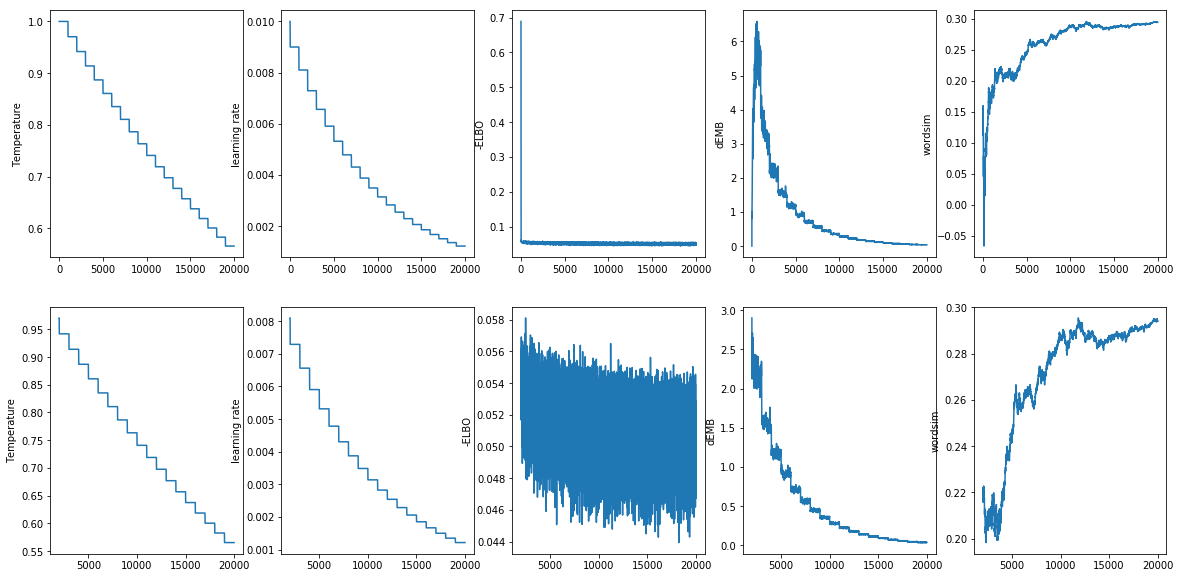

In [479]:
np_dat = np.array(dat).T
fig, axarr = plt.subplots(2, (np_dat.shape[0]-1))
fig.set_size_inches((20,10))
ylabels = ['Temperature', 'learning rate', '-ELBO', 'dEMB', 'wordsim']
for i in range(np_dat.shape[0] - 1):
    axarr[0][i].plot(np_dat[0], np_dat[i+1])
    axarr[0][i].set_ylabel(ylabels[i])
for i in range(np_dat.shape[0] - 1):
    axarr[1][i].plot(np_dat[0, 2000:], np_dat[i+1, 2000:])
    axarr[1][i].set_ylabel(ylabels[i])

## 6. probabilistic w2v plot

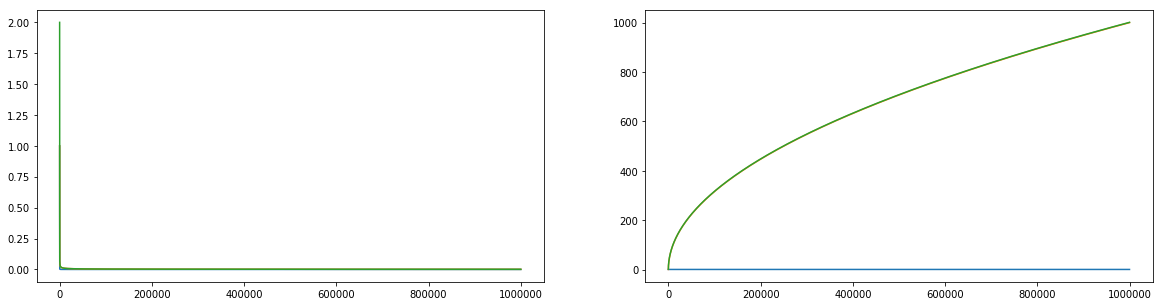

In [101]:
def subsample_plot():
    x = np.array(range(1, 1000000))
    y1 = 1 / x
    y2 = np.sqrt(1 / x)
    y3 = y1 + y2
    c1 = y1 * x
    c2 = y2 * x
    c3 = y3 * x
    f, a = plt.subplots(1, 2)
    f.set_size_inches((20, 5))
    a[0].plot(x, y1)
    a[0].plot(x, y2)
    a[0].plot(x, y3)
    a[1].plot(x, c1)
    a[1].plot(x, c2)
    a[1].plot(x, c3)
    plt.show()
subsample_plot()

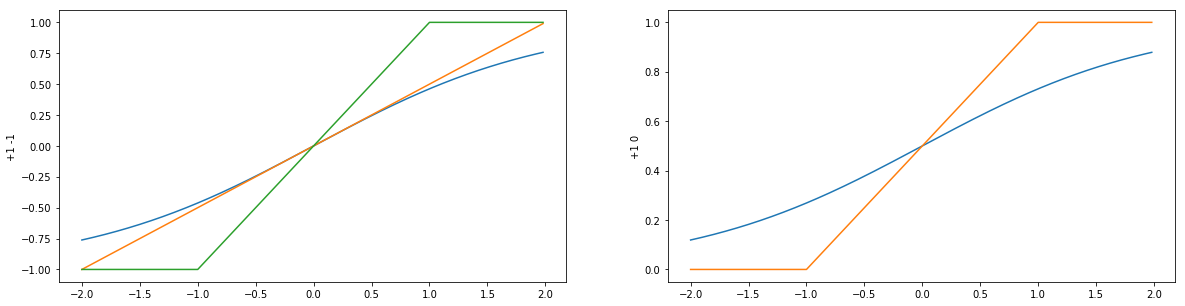

In [5]:
def binary_func_plot():
    x = np.array(range(-100, 100)) / 50
    y1 = (np.exp(x) - 1) / (np.exp(x) + 1)
    y2 = np.exp(x) / (np.exp(x) + 1)
    f, a = plt.subplots(1, 2)
    f.set_size_inches((20, 5))
    a[0].plot(x, y1)
    a[0].plot(x, 0.5 * x)
    a[0].plot(x, 2 * (np.clip(0.5 * x + 0.5, 0, 1) - 0.5))
    a[0].set_ylabel('+1 -1')
    a[1].plot(x, y2)
    a[1].set_ylabel('+1 0')
    a[1].plot(x, np.clip(0.5 * x + 0.5, 0, 1))
    plt.show()
binary_func_plot()

The raw real value x in [-1, 1] is linearly scaled to [-0.4, 0.4], which is about the half of the raw. That could explain why rollback is effective.

In [252]:
def load_interaction(filename, cate_n, cate_k):
    inter = []
    with open(filename, 'r') as fp:
        for l in fp:
            for i in l.split():
                inter.append(float(i))
    return np.array(inter).reshape(cate_n, cate_k, cate_k)

In [277]:
inter = load_interaction('../word2vec/vec/wiki_context_interaction_size100-5_epoch1_s5_m10.interaction', 100, 5)

In [279]:
inter.tolist()

[[[0.003344, 0.009816, -0.000207, -0.015596, 0.001572],
  [-0.014229, 0.000768, 0.006331, 0.011068, -0.004376],
  [-0.003973, -0.026024, 0.021354, 0.026199, -0.018658],
  [0.003673, -0.000149, 0.024343, -0.027648, -0.002633],
  [0.007885, 0.013242, -0.025139, -0.013564, 0.017506]],
 [[-0.005211, -0.005688, -0.004265, 0.01279, 0.000724],
  [0.011754, -0.007136, -0.003388, -0.002201, 0.00168],
  [0.013171, 0.012868, -0.017022, -0.028695, 0.020908],
  [0.065285, -0.004495, -0.02998, -0.03567, 0.005199],
  [-0.007954, 0.03764, -0.010024, -0.019626, 0.000125]],
 [[0.013328, 0.003898, 0.010918, -0.01003, -0.018463],
  [-0.005358, 0.000372, -0.004556, 0.008142, 0.003126],
  [-7.3e-05, 0.005945, -0.009548, -0.003828, 0.007587],
  [-0.010485, -0.015772, 0.002067, 0.006673, 0.016989],
  [0.009628, -0.014475, -0.017745, 0.010393, 0.012255]],
 [[-0.00707, 0.010853, -0.003895, 0.003268, -0.002027],
  [-0.008531, 0.015382, -0.010552, 0.025568, -0.022082],
  [0.012486, -0.004259, 0.014542, -0.028645,

In [24]:
def unit_norm(vec):
    return 2 * vec / np.sqrt(np.sum(vec * vec)) # 2 is for better visualization
def avg_nozeor(vec):
    return np.sum(np.exp(vec) / (1 + np.exp(vec)))
def get_ent(vec):
    return -np.sum(vec * np.log2(vec)) / vec.shape[0]
def plot_ent(vec):
    ents = np.average(-np.sum(vec * np.log2(vec), axis=2), axis=1)
    plt.scatter(range(len(ents)), ents, s=1)
    plt.ylabel('ent')
    plt.xlabel('word rank')
    plt.show()
def dim_explain(vec):
    return np.sort(np.mean(vec, axis=0))
def dim_corr(vec):
    corr = []
    for c1, c2 in combinations(range(vec.shape[1]), 2):
        corr.append(stats.pearsonr(vec[:, c1], vec[:, c2]))
    return np.average(corr)
def vis_emb_at(emb, ind_or_word, prob=True):
    if type(ind_or_word) is int:
        ind = ind_or_word
        word = emb.index2word[ind_or_word]
    elif type(ind_or_word) is str:
        word = ind_or_word
        ind = emb.vocab[word].index
    axes = plt.gca()    
    if prob:
        axes.set_ylim([0, 1])
        dim = emb[word].shape[0] // 2;
        print(ind, word, get_ent(emb[word].reshape(1, -1)) / dim)
        plt.scatter(range(dim), emb[word].reshape(dim, 2)[:, 0])
    else:
        axes.set_ylim([-1, 1])
        dim = emb[word].shape[0];
        print(ind, word)
        plt.scatter(range(dim), emb[word])
    plt.show()
def vis_emb_list(emb, li, inter=0.3, prob=True, norm=False):
    f, ax = plt.subplots(1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for ind_or_word in li:
        if type(ind_or_word) is int:
            ind = ind_or_word
            word = emb.index2word[ind_or_word]
        elif type(ind_or_word) is str:
            word = ind_or_word
            ind = emb.vocab[word].index
        if prob:
            dim = emb[word].shape[0] // 2
            print(ind, word, get_ent(emb[word].reshape(1, -1)) / dim)
        else:
            dim = emb[word].shape[0]
            print(ind, word)
        ax.cla()
        if prob:
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(-1, 1)
        if ax.lines:
            for line in ax.lines:
                if prob:
                    line.set_ydata(unit_norm(emb[word].reshape(dim, 2)[:, 0]) if norm else emb[word].reshape(dim, 2)[:, 0])
                else:
                    line.set_ydata(unit_norm(emb[word]) if norm else emb[word])
        else:
            if prob:
                ax.scatter(range(dim), unit_norm(emb[word].reshape(dim, 2)[:, 0]) if norm else emb[word].reshape(dim, 2)[:, 0])
            else:
                ax.scatter(range(dim), unit_norm(emb[word]) if norm else emb[word])
        f.canvas.draw()
        time.sleep(inter)

In [128]:
baseline_w2v = KeyedVectors.load_word2vec_format('../word2vec/vec/text8_w2v_100_s5_m10_epoch10.prob.bin', binary=True)

0.0259367877047
0.981823379654


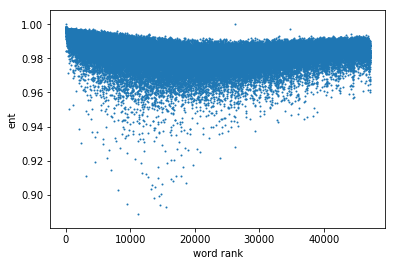

In [129]:
print(dim_corr(baseline_w2v.syn0.reshape(-1, 100, 2)[:, :, 0]))
print(get_ent(baseline_w2v.syn0.reshape(-1, 100, 2)) / 100)
plot_ent(baseline_w2v.syn0.reshape(-1, 100, 2))

In [130]:
baseline_w2v_wiki = KeyedVectors.load_word2vec_format('../word2vec/vec/wiki_w2v_100_s5_m10_epoch5.prob.bin', binary=True)

0.981872082115


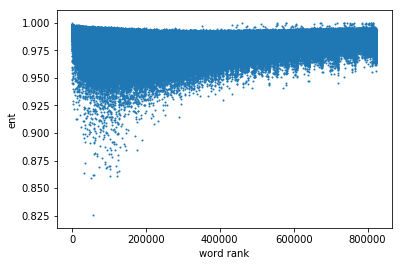

In [132]:
#print(dim_corr(baseline_w2v_wiki.syn0.reshape(-1, 100, 2)[:, :, 0]))
print(get_ent(baseline_w2v_wiki.syn0.reshape(-1, 100, 2)) / 100)
plot_ent(baseline_w2v_wiki.syn0.reshape(-1, 100, 2))

In [10]:
test_emb4 = KeyedVectors.load_word2vec_format('../word2vec/vec/test100-2-nofree.prob.bin', binary=True)

In [12]:
dim_corr(test_emb4.syn0.reshape(-1, 100, 2)[:, :, 0])

0.0095750072463852698

0.608930089352


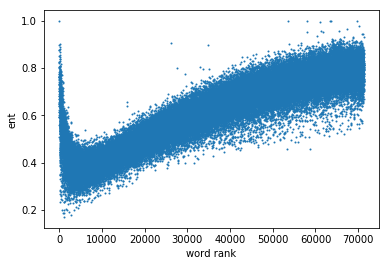

In [52]:
print(get_ent(test_emb4.syn0.reshape(-1, 100, 2)) / 100)
plot_ent(test_emb4.syn0.reshape(-1, 100, 2))

In [14]:
test_emb2 = KeyedVectors.load_word2vec_format('../word2vec/vec/test100-2-posterior_epoch10.prob.bin', binary=True)

In [15]:
dim_corr(test_emb2.syn0.reshape(-1, 100, 2)[:, :, 0])

0.006588596683118635

0.944281466104


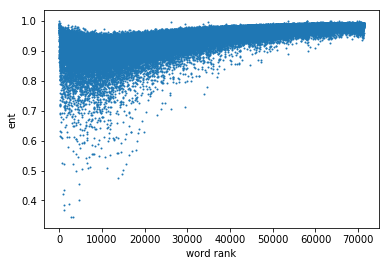

In [51]:
print(get_ent(test_emb2.syn0.reshape(-1, 100, 2)) / 100)
plot_ent(test_emb2.syn0.reshape(-1, 100, 2))

In [17]:
test_emb3 = KeyedVectors.load_word2vec_format('../word2vec/vec/test100-2_free_epoch20.prob.bin', binary=True)

0.906338668275


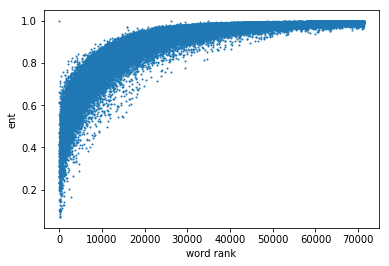

In [50]:
print(get_ent(test_emb3.syn0.reshape(-1, 100, 2)) / 100)
plot_ent(test_emb3.syn0.reshape(-1, 100, 2))

1.95732174128


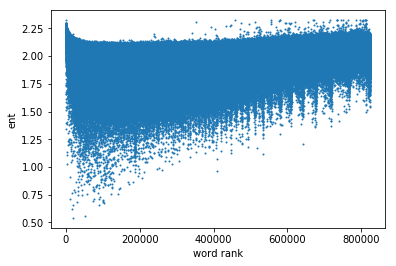

In [241]:
#test_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/test_posterior_epoch20_w2v10.prob.bin', binary=True)
#test_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/wiki_context_size100-5_epoch30_s8_m10_lr25.prob.bin', binary=True)
#test_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/text8_context_skl_size100-5_epoch30_s5_m10.prob.bin', binary=True)
test_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/wiki_context_skl_size100-5_epoch5_s5_m10_lr25.prob.bin', binary=True)
print(get_ent(test_emb.syn0.reshape(-1, 100, 5)) / 100)
plot_ent(test_emb.syn0.reshape(-1, 100, 5))

In [244]:
test_emb_gate = KeyedVectors.load_word2vec_format('../word2vec/vec/test3.gate.bin', binary=True)

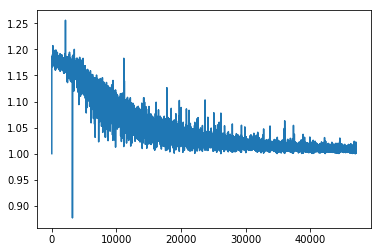

In [251]:
plt.plot(range(test_emb_gate.syn0.shape[0]), test_emb_gate.syn0.reshape(-1))

<IPython.core.display.Javascript object>


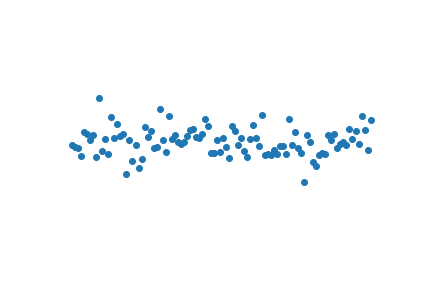

1 the 0.99698928833
21 four 0.99407081604
41 has 0.991089096069
61 after 0.994648590088
81 years 0.98822555542
101 city 0.992155838013
121 name 0.993544921875
141 language 0.988906936646
161 based 0.993384246826
181 series 0.992235031128
201 political 0.991963653564
221 small 0.994283599854
241 important 0.991549987793
261 thus 0.997902679443
281 led 0.993089523315
301 according 0.995078430176
321 greek 0.990402832031
341 body 0.994447479248
361 team 0.990785522461
381 soviet 0.983757324219
401 culture 0.993037948608
421 play 0.99300239563
441 story 0.993720550537
461 actor 0.979497070312
481 program 0.993768463135
501 latin 0.989318466187
521 traditional 0.994319610596
541 note 0.9952784729
561 africa 0.986916503906
581 rock 0.987531738281
601 education 0.990791931152
621 eventually 0.995330352783
641 problems 0.992465057373
661 deaths 0.97720375061
681 video 0.985751647949
701 cause 0.992713546753
721 changes 0.994550704956
741 provide 0.993052062988
761 across 0.993206176758
781 sai

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


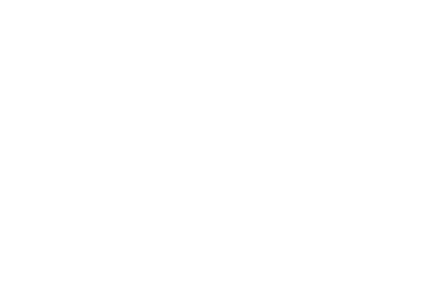

In [287]:
vis_emb_list(KeyedVectors.load_word2vec_format('../word2vec/vec/text8_w2v_100_epoch10.prob.bin', binary=True), 
             range(1, 10000, 20), inter=0.05, prob=True, norm=False)

<IPython.core.display.Javascript object>


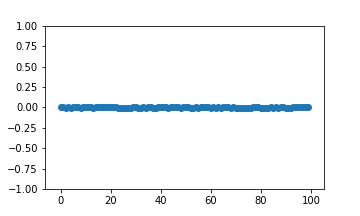

40000 juntas
40010 moire
40020 vlaams
40030 amylase
40040 rower
40050 telecasts
40060 councilors
40070 margherita
40080 interoperable
40090 stench
40100 baylor
40110 matsui
40120 triadic
40130 crowding
40140 amenable
40150 skaldic
40160 sesotho
40170 camcorder
40180 cem
40190 excuses
40200 biotech
40210 ibero
40220 kary
40230 shorthair
40240 brp
40250 hoo
40260 koenig
40270 nowy
40280 monuc
40290 lonsdaleite
40300 handhelds
40310 alessandri
40320 larnaca
40330 messe
40340 cowpox
40350 cherries
40360 martingale
40370 apps
40380 reconfigurable
40390 matre
40400 hula
40410 ericaceae
40420 awm
40430 metabolite
40440 endo
40450 fandango
40460 denaturation
40470 trooper
40480 tesco
40490 pamphilus
40500 mondeo
40510 publicacion
40520 conservatorio
40530 karaites
40540 ridinghood
40550 kittiwake
40560 chobert
40570 tendon
40580 shoals
40590 essences
40600 philanthropy
40610 extremism
40620 jonson
40630 upa
40640 steffi
40650 workhorse
40660 bewildering
40670 alerts
40680 anticipates
40690 lan

45650 hvac
45660 mulder
45670 bowmen
45680 gico
45690 countercultural
45700 micros
45710 bes
45720 solemnity
45730 segmentata
45740 eac
45750 atlantean
45760 shay
45770 gaians
45780 philly
45790 emanation
45800 constriction
45810 setups
45820 mahoney
45830 inconsistently
45840 marketshare
45850 mistranslation
45860 lillehammer
45870 zuma
45880 coq
45890 inductee
45900 nugent
45910 lomond
45920 finnegan
45930 marija
45940 yearning
45950 scalpel
45960 jaffe
45970 tut
45980 ausgleich
45990 rds
46000 absentia
46010 graziani
46020 servicio
46030 infantryman
46040 polonaise
46050 ontogeny
46060 remaking
46070 horizonte
46080 fiske
46090 troppo
46100 derailed
46110 acr
46120 brainstem
46130 mindstorms
46140 nei
46150 orcs
46160 beaconsfield
46170 pickguard
46180 tianjin
46190 fluctuates
46200 adages
46210 dimorphism
46220 putonghua
46230 rahilly
46240 zel
46250 allophonic
46260 outpouring
46270 rabinowitz
46280 whedon
46290 suevi
46300 mep
46310 konerko
46320 hypertrophy
46330 meribbaal
46340

In [26]:
vis_emb_list(KeyedVectors.load_word2vec_format('../word2vec/vec/test.bin', binary=True), 
             range(40000, 50000, 10), inter=0.05, prob=False, norm=False)

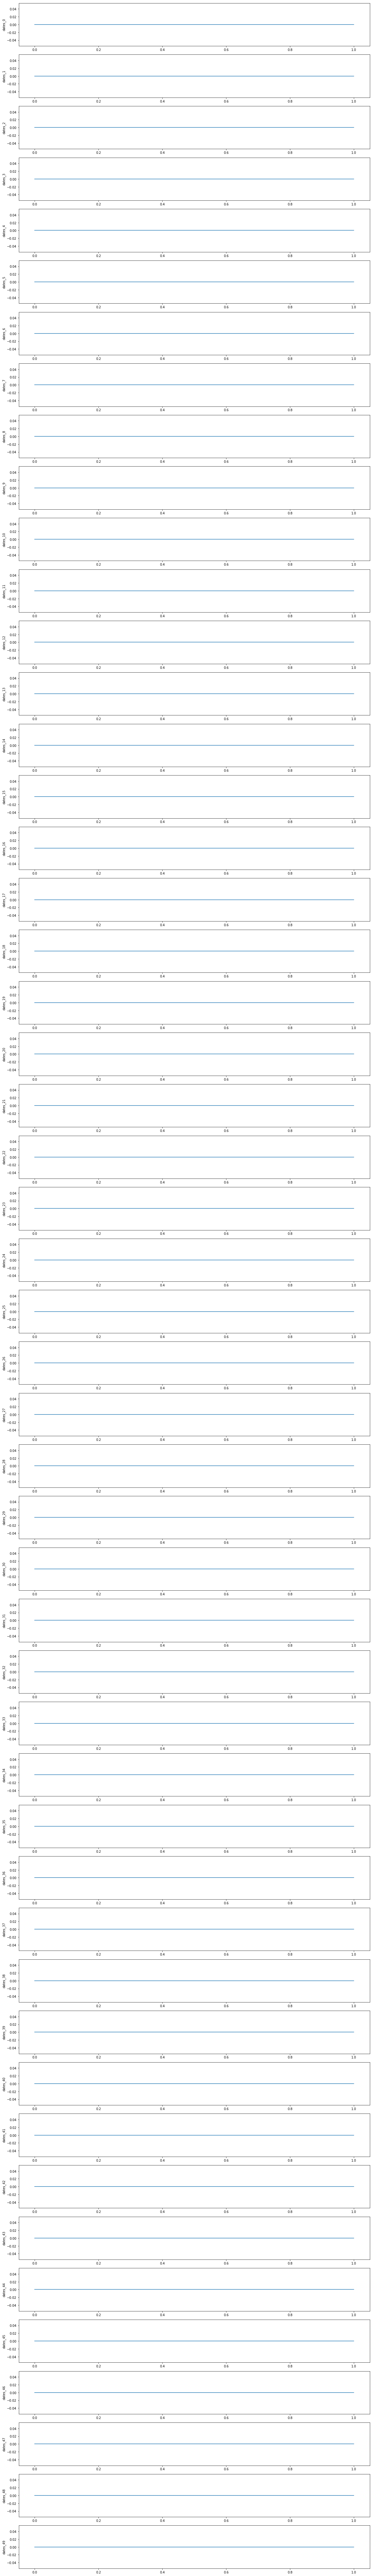

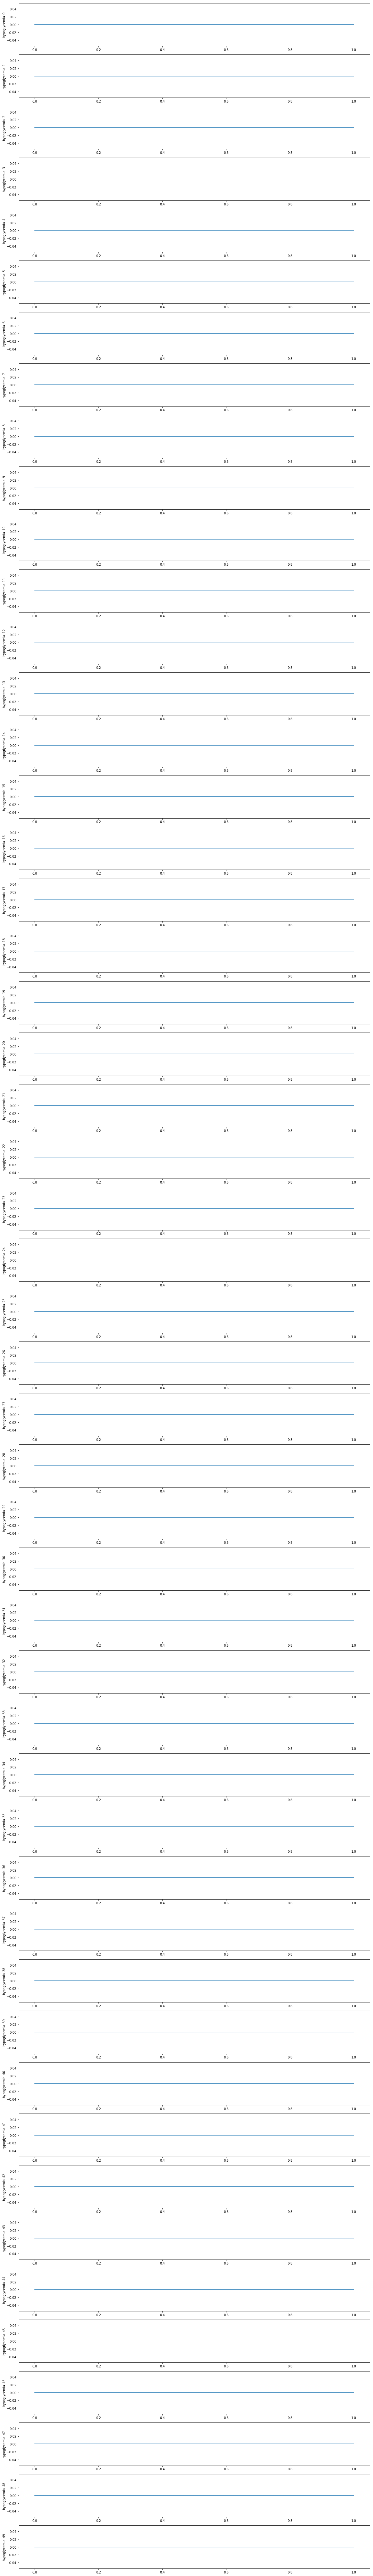

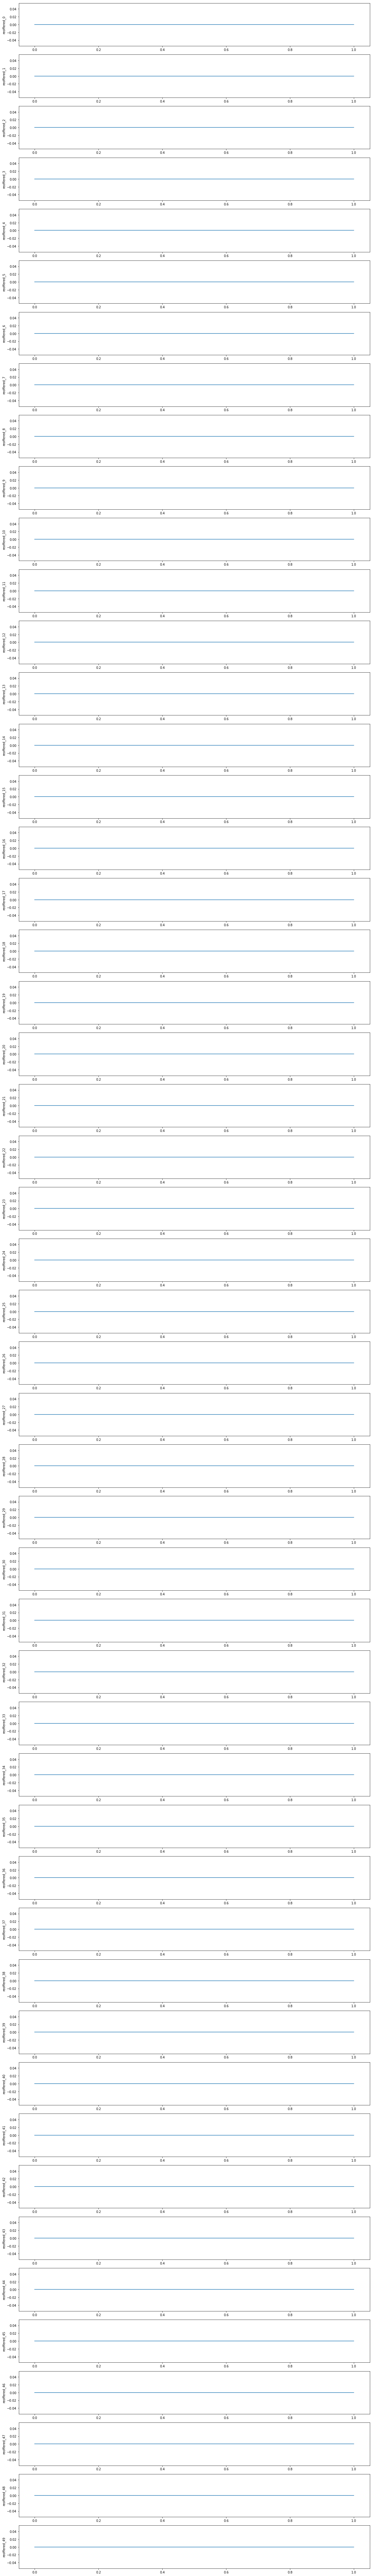

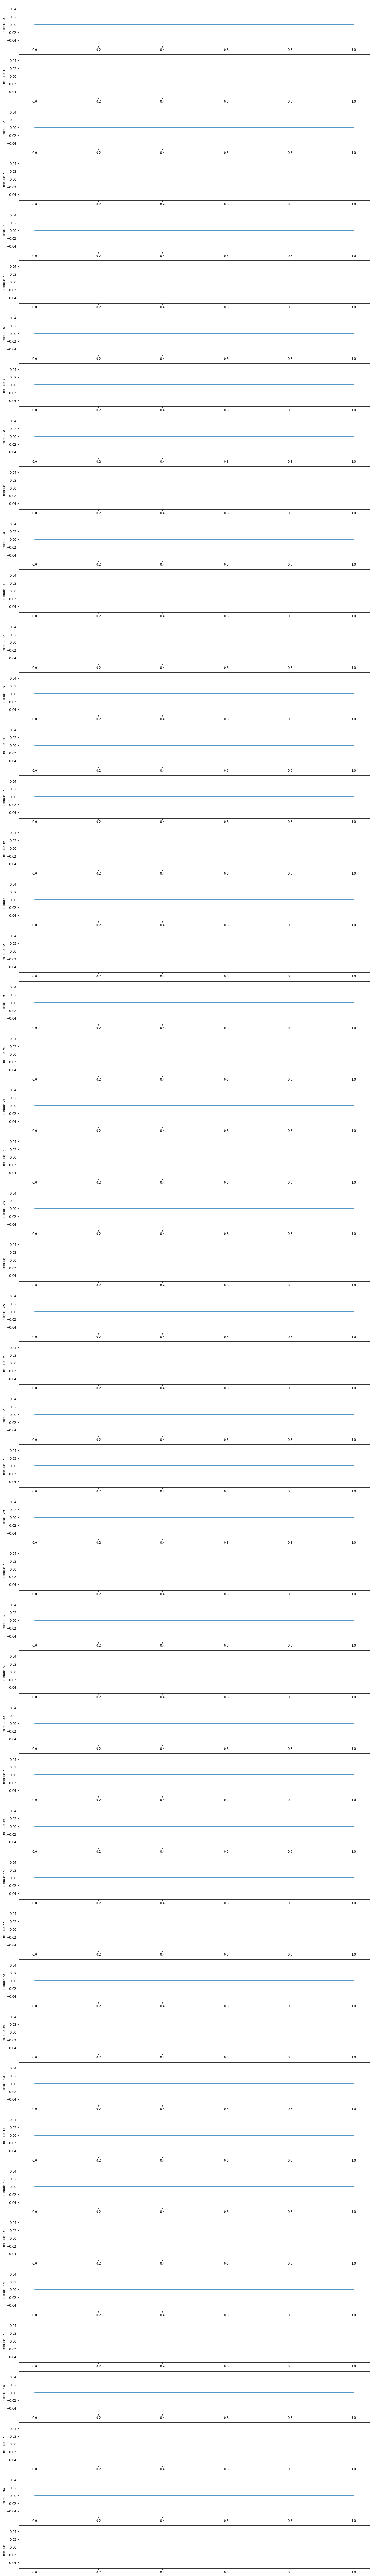

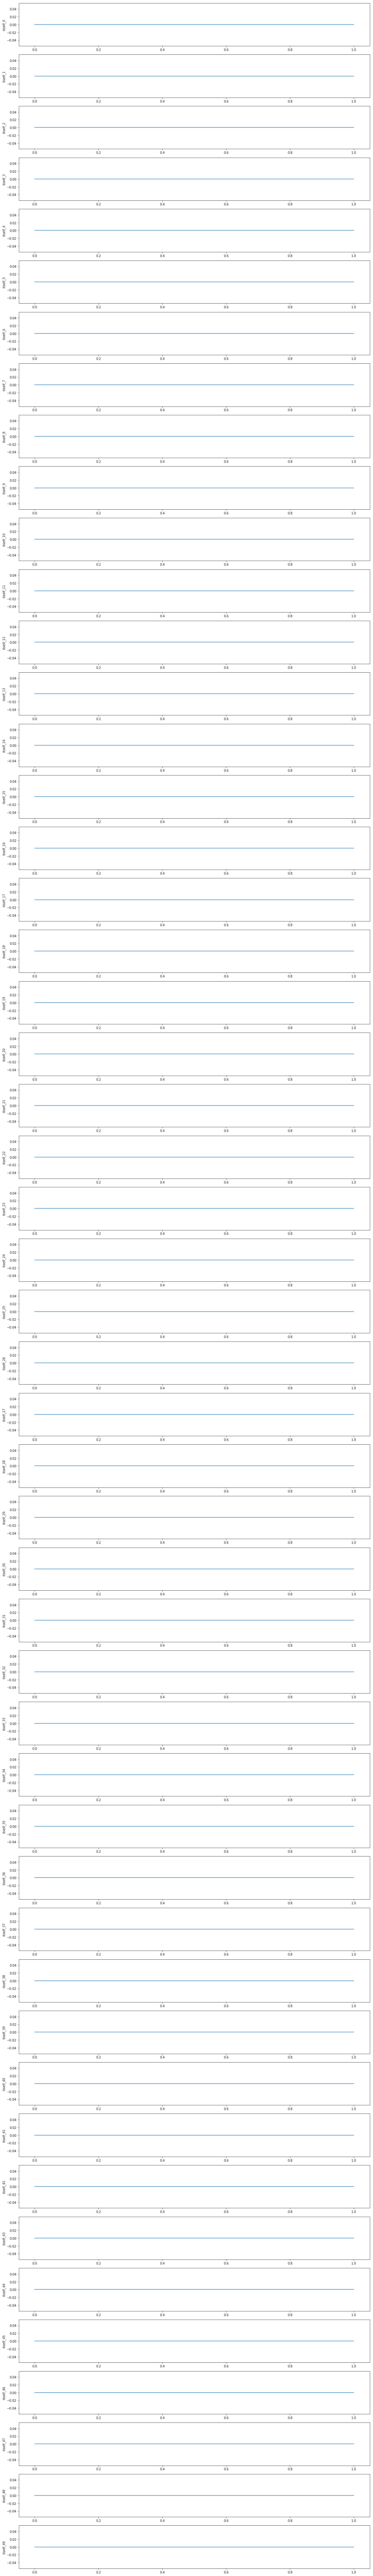

In [71]:
test_emb = KeyedVectors.load_word2vec_format('../word2vec/vec/ptb_size50-2_epoch5_novi.context.bin', binary=True)
np_logit_prob = test_emb.syn0.reshape(test_emb.syn0.shape[0], 50, 2)
for i in np.random.permutation(np_logit_prob.shape[0])[:5]:
    #print(i, vocab.decode(i))
    tfig, taxarr = plt.subplots(50, 1)
    tfig.set_size_inches((20, 3 * 50))
    if 50 == 1:
        taxarr.plot(np_logit_prob[i][j])
        taxarr.set_ylabel('{}_{}'.format(test_emb.index2word[i], 1))
        continue
    for j in range(50):
        taxarr[j].plot(np_logit_prob[i][j])
        taxarr[j].set_ylabel('{}_{}'.format(test_emb.index2word[i], j))

In [191]:
np_logit_prob = sess.run(tf.reshape(tf.nn.softmax(tf.reshape(logit_emb, [-1, K])), [-1, N, K]))

In [245]:
dim_explain(test_emb3.syn0.reshape(-1, 10, 2)[:, :, 0])

array([ 0.41557527,  0.41853926,  0.41961879,  0.42068449,  0.42295513,
        0.42379984,  0.42467576,  0.42768702,  0.42821449,  0.43276036], dtype=float32)

(10000, 10, 10)


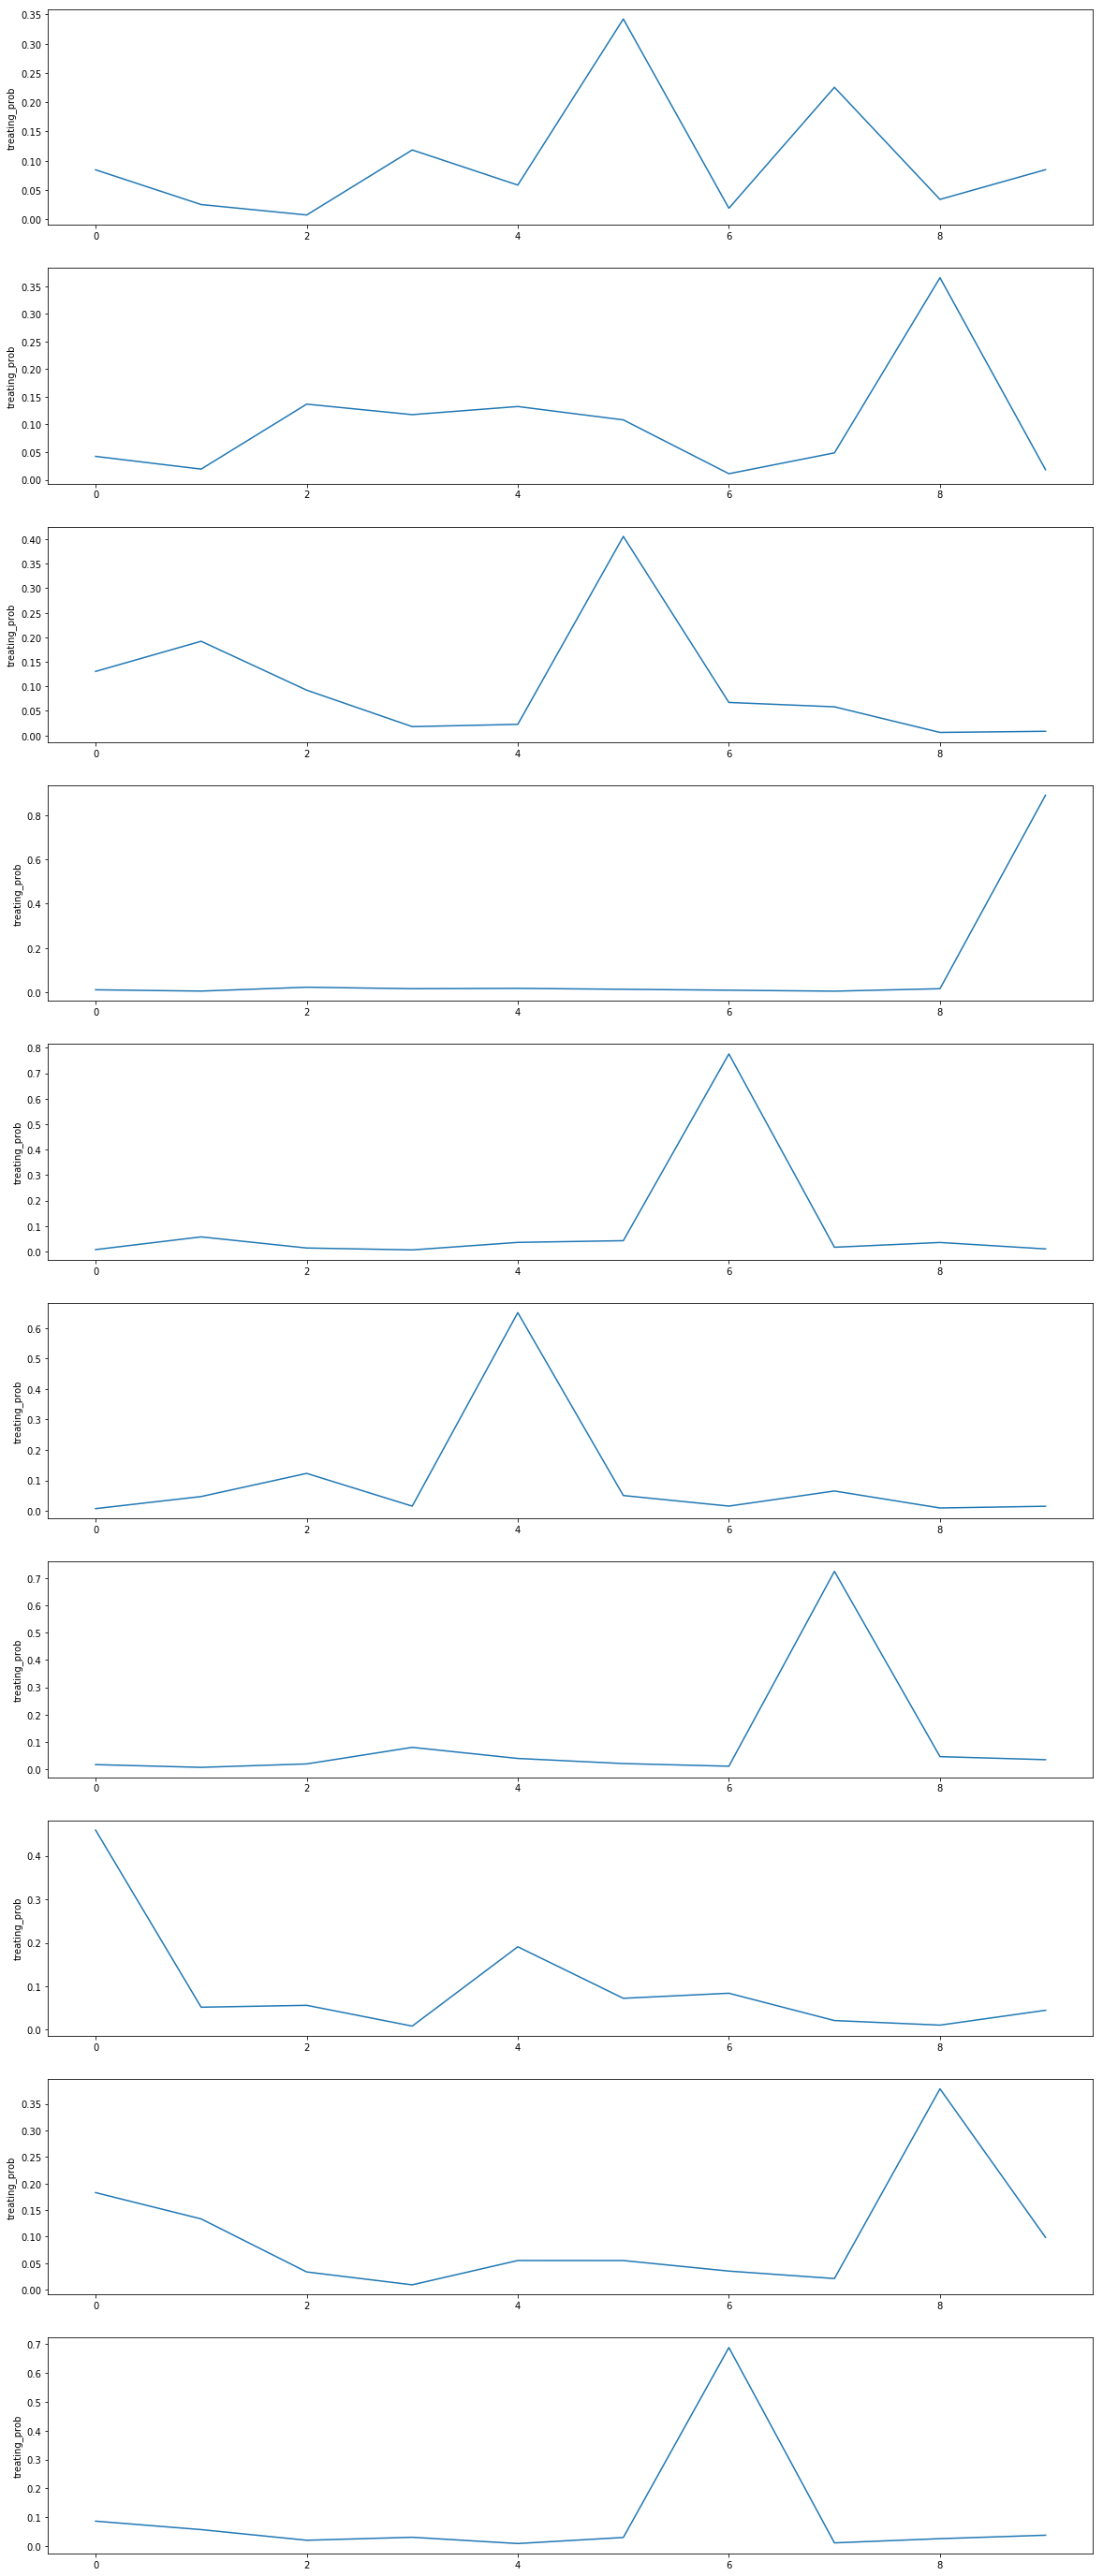

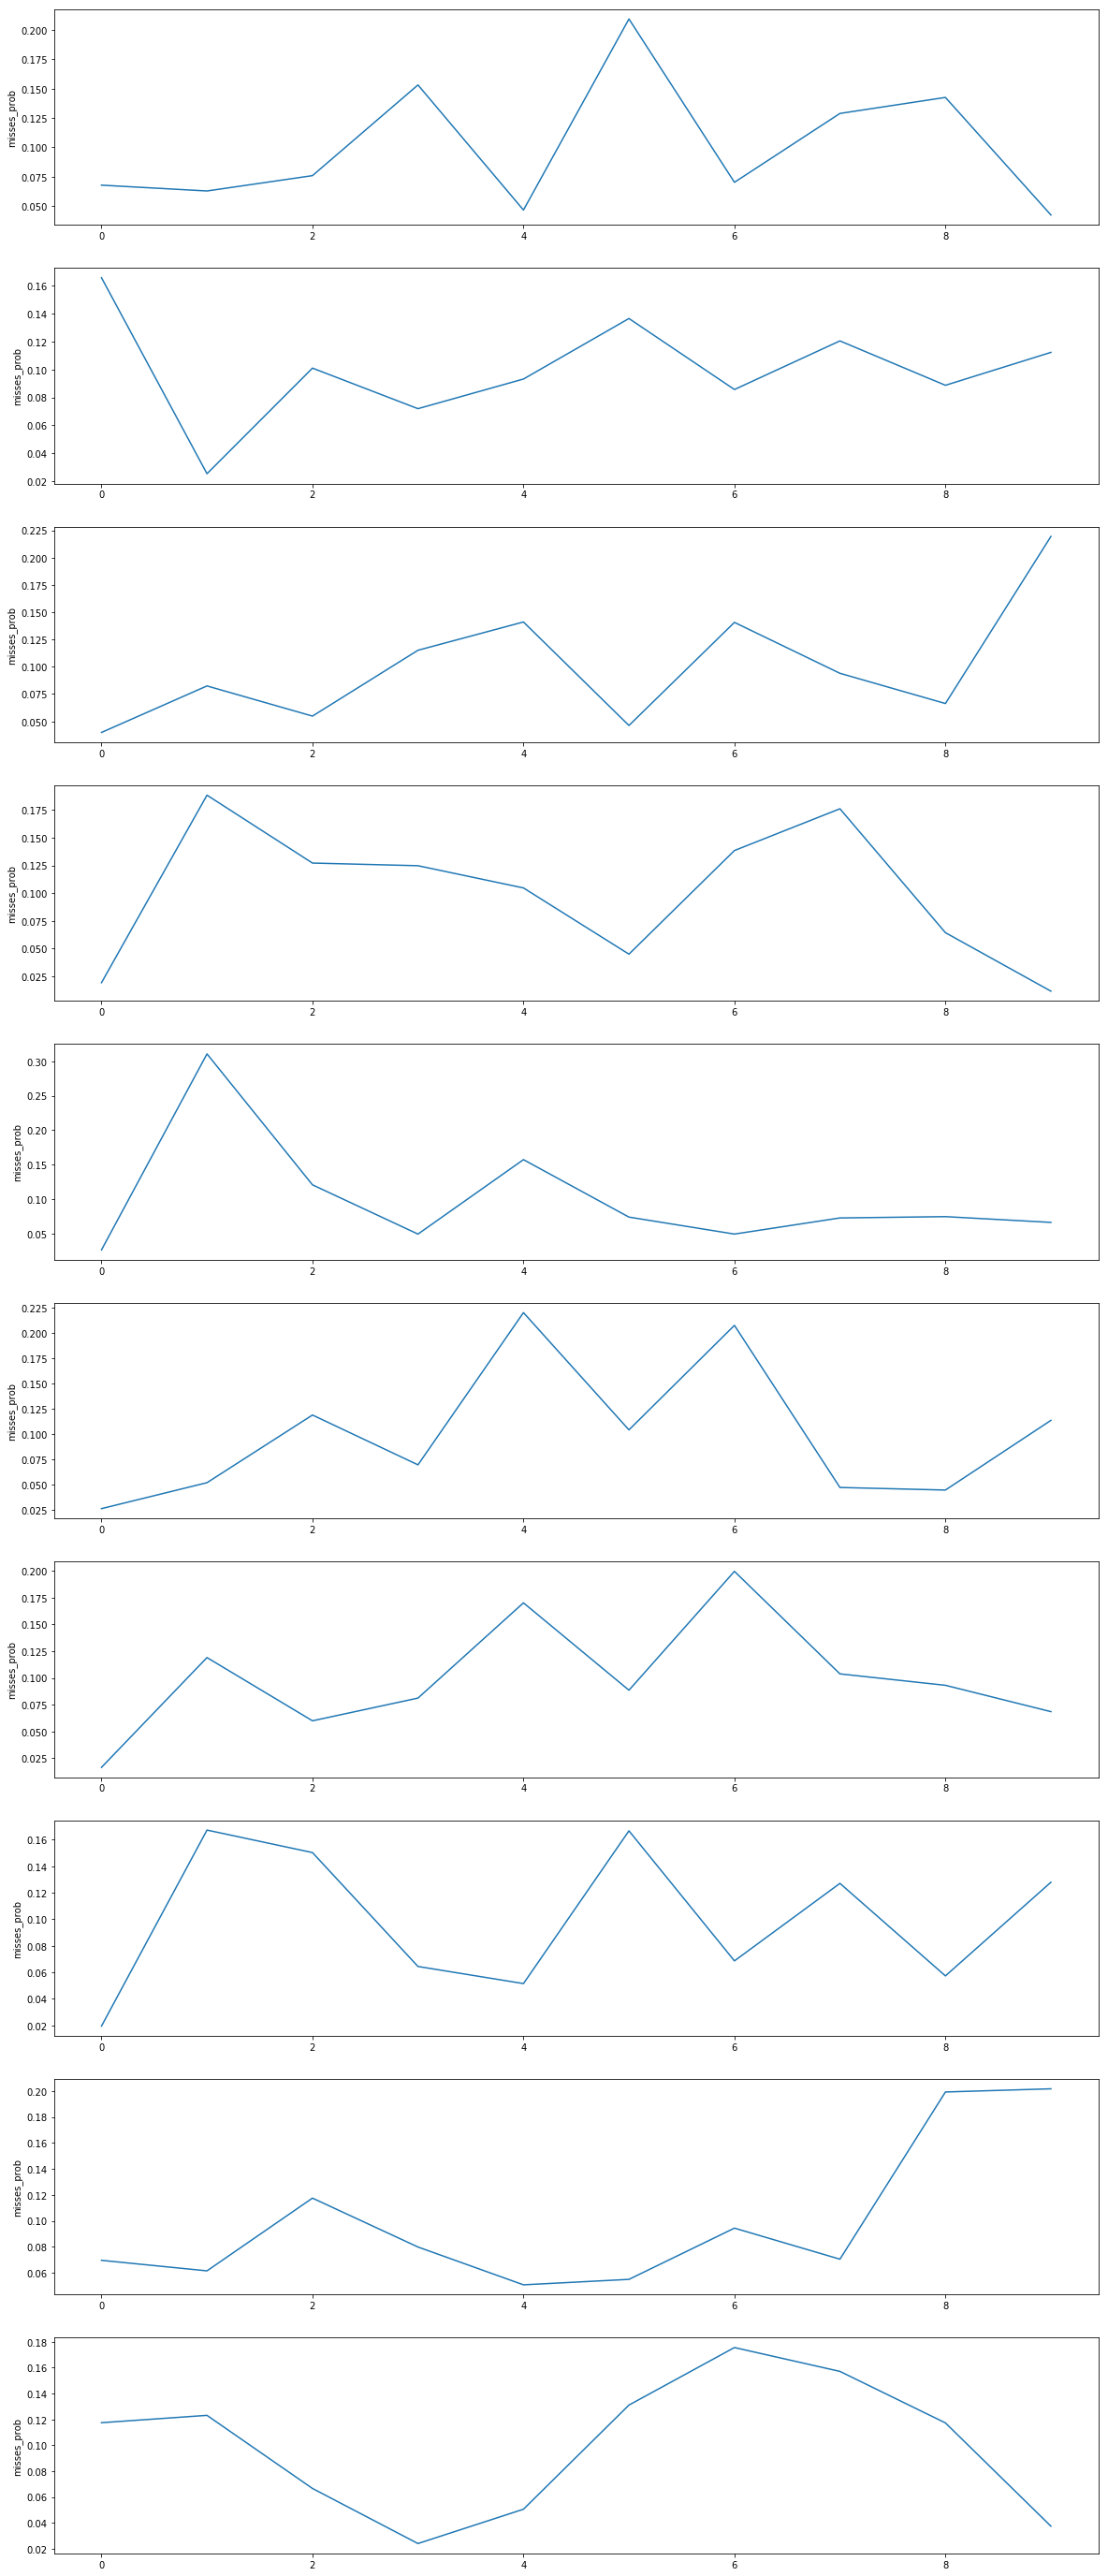

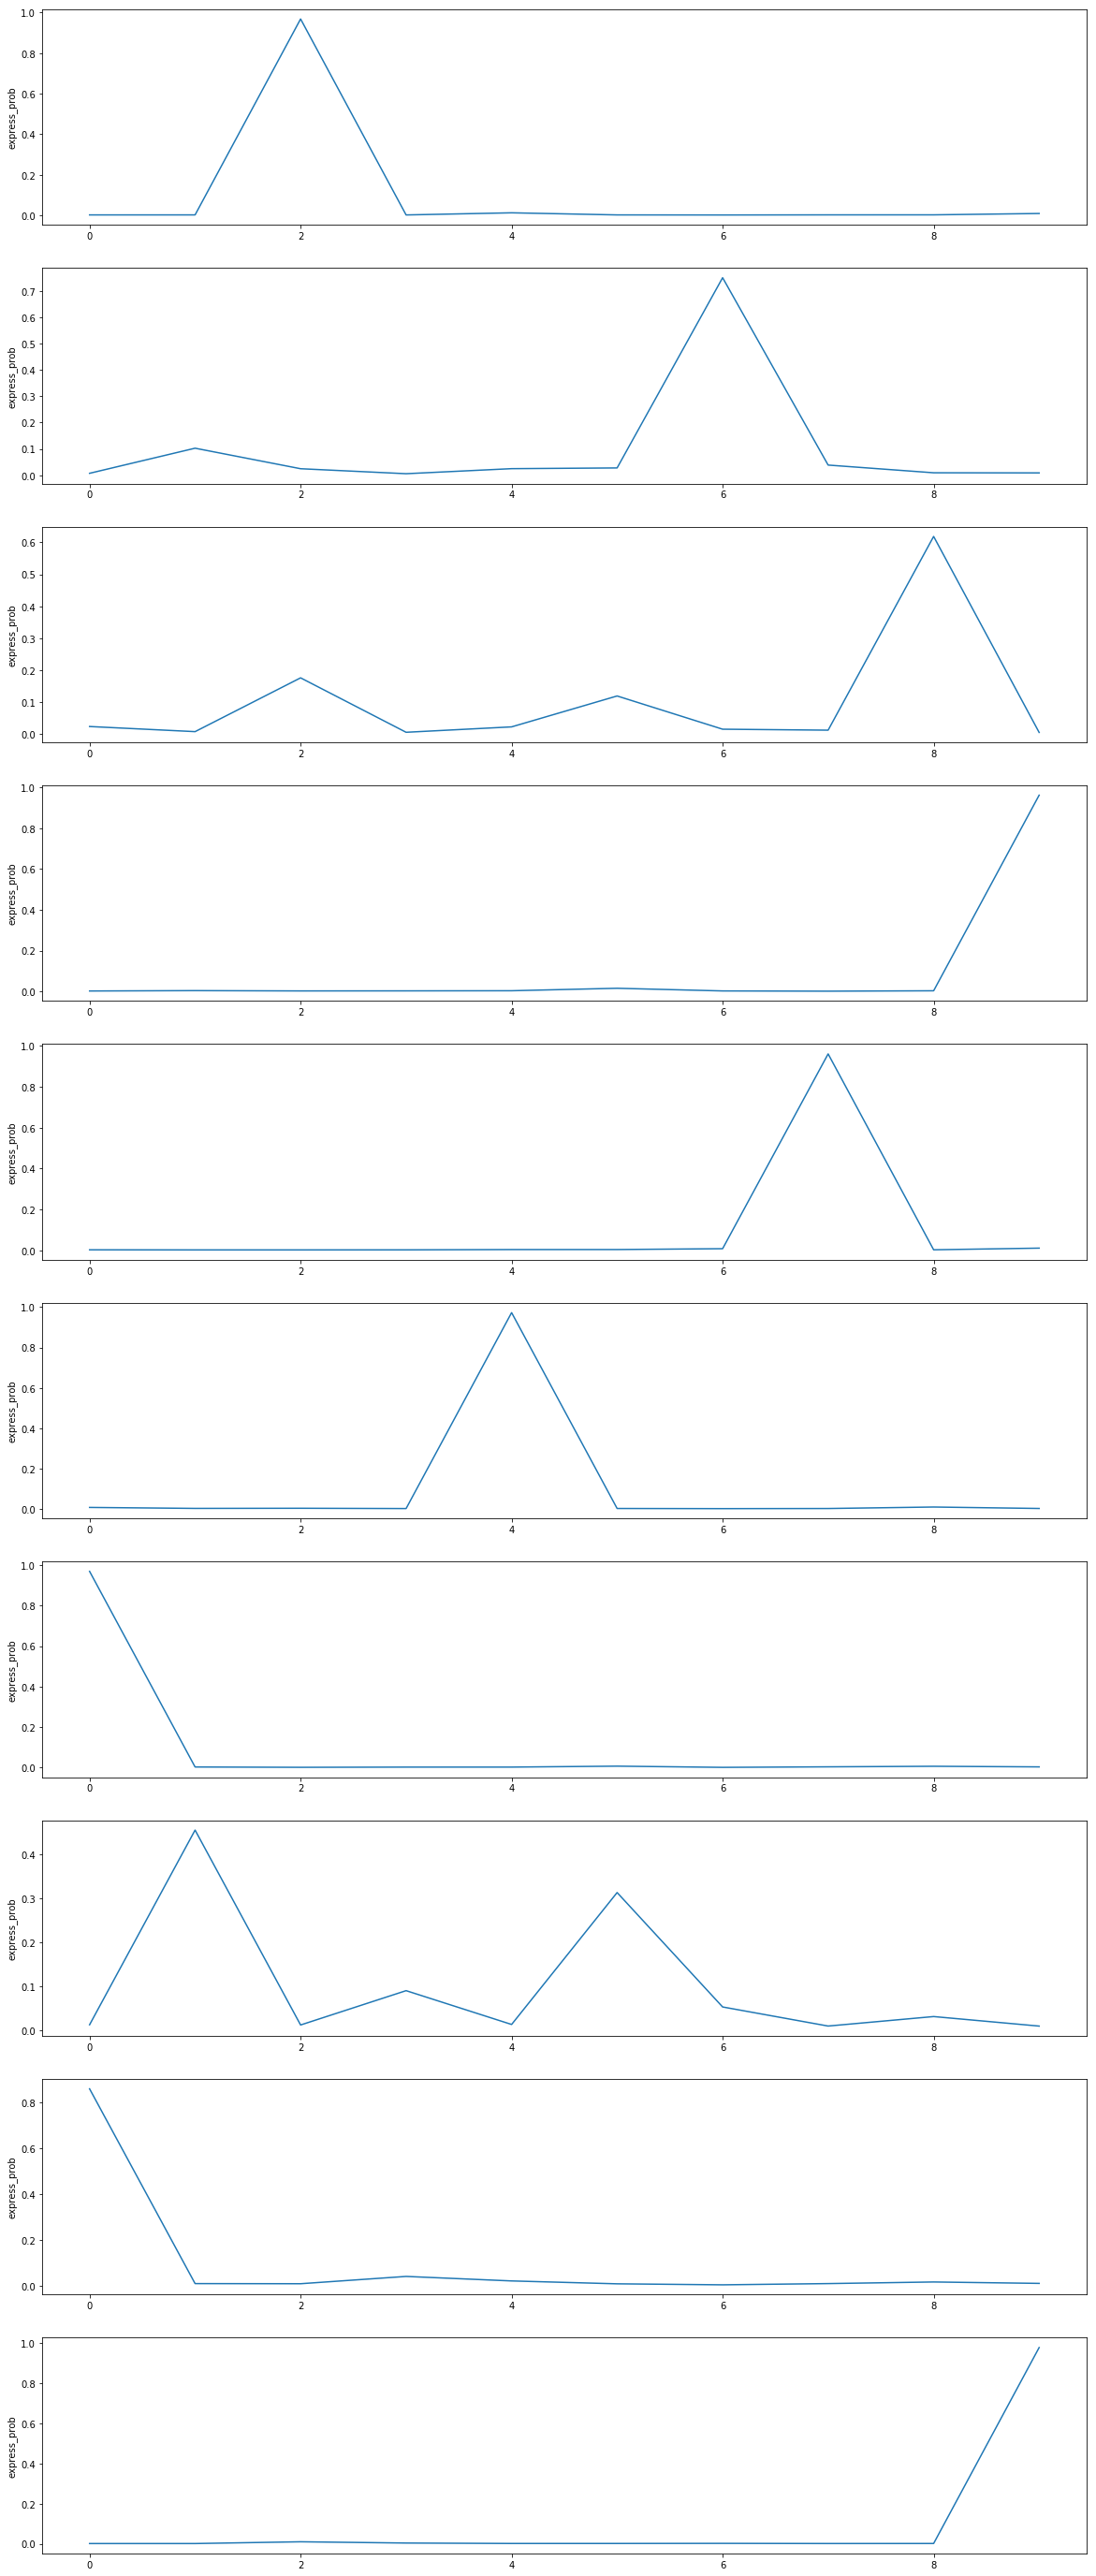

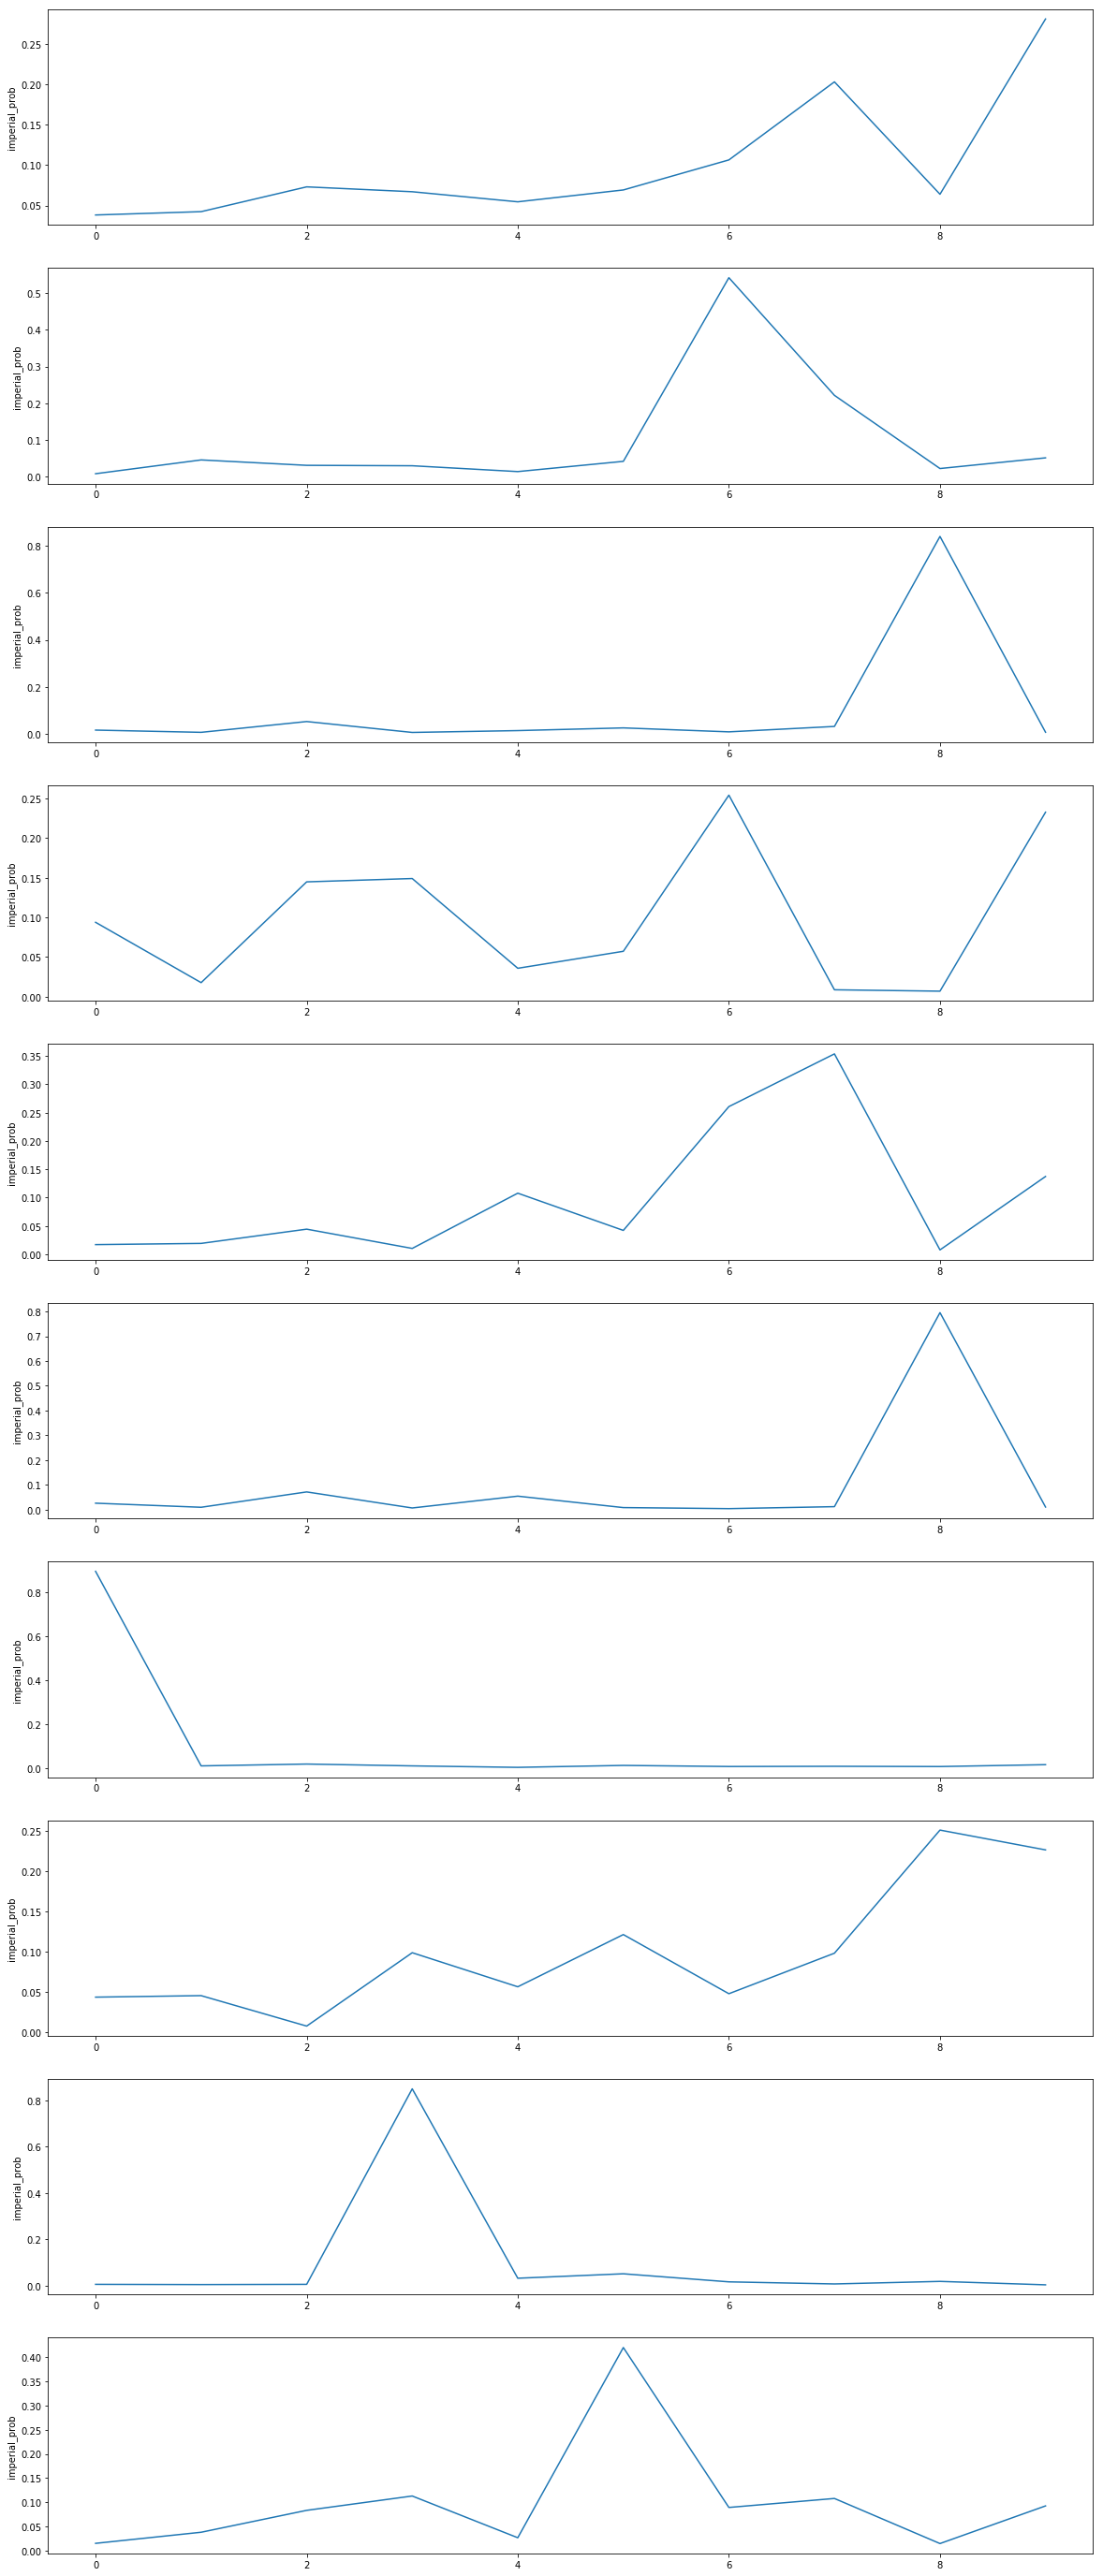

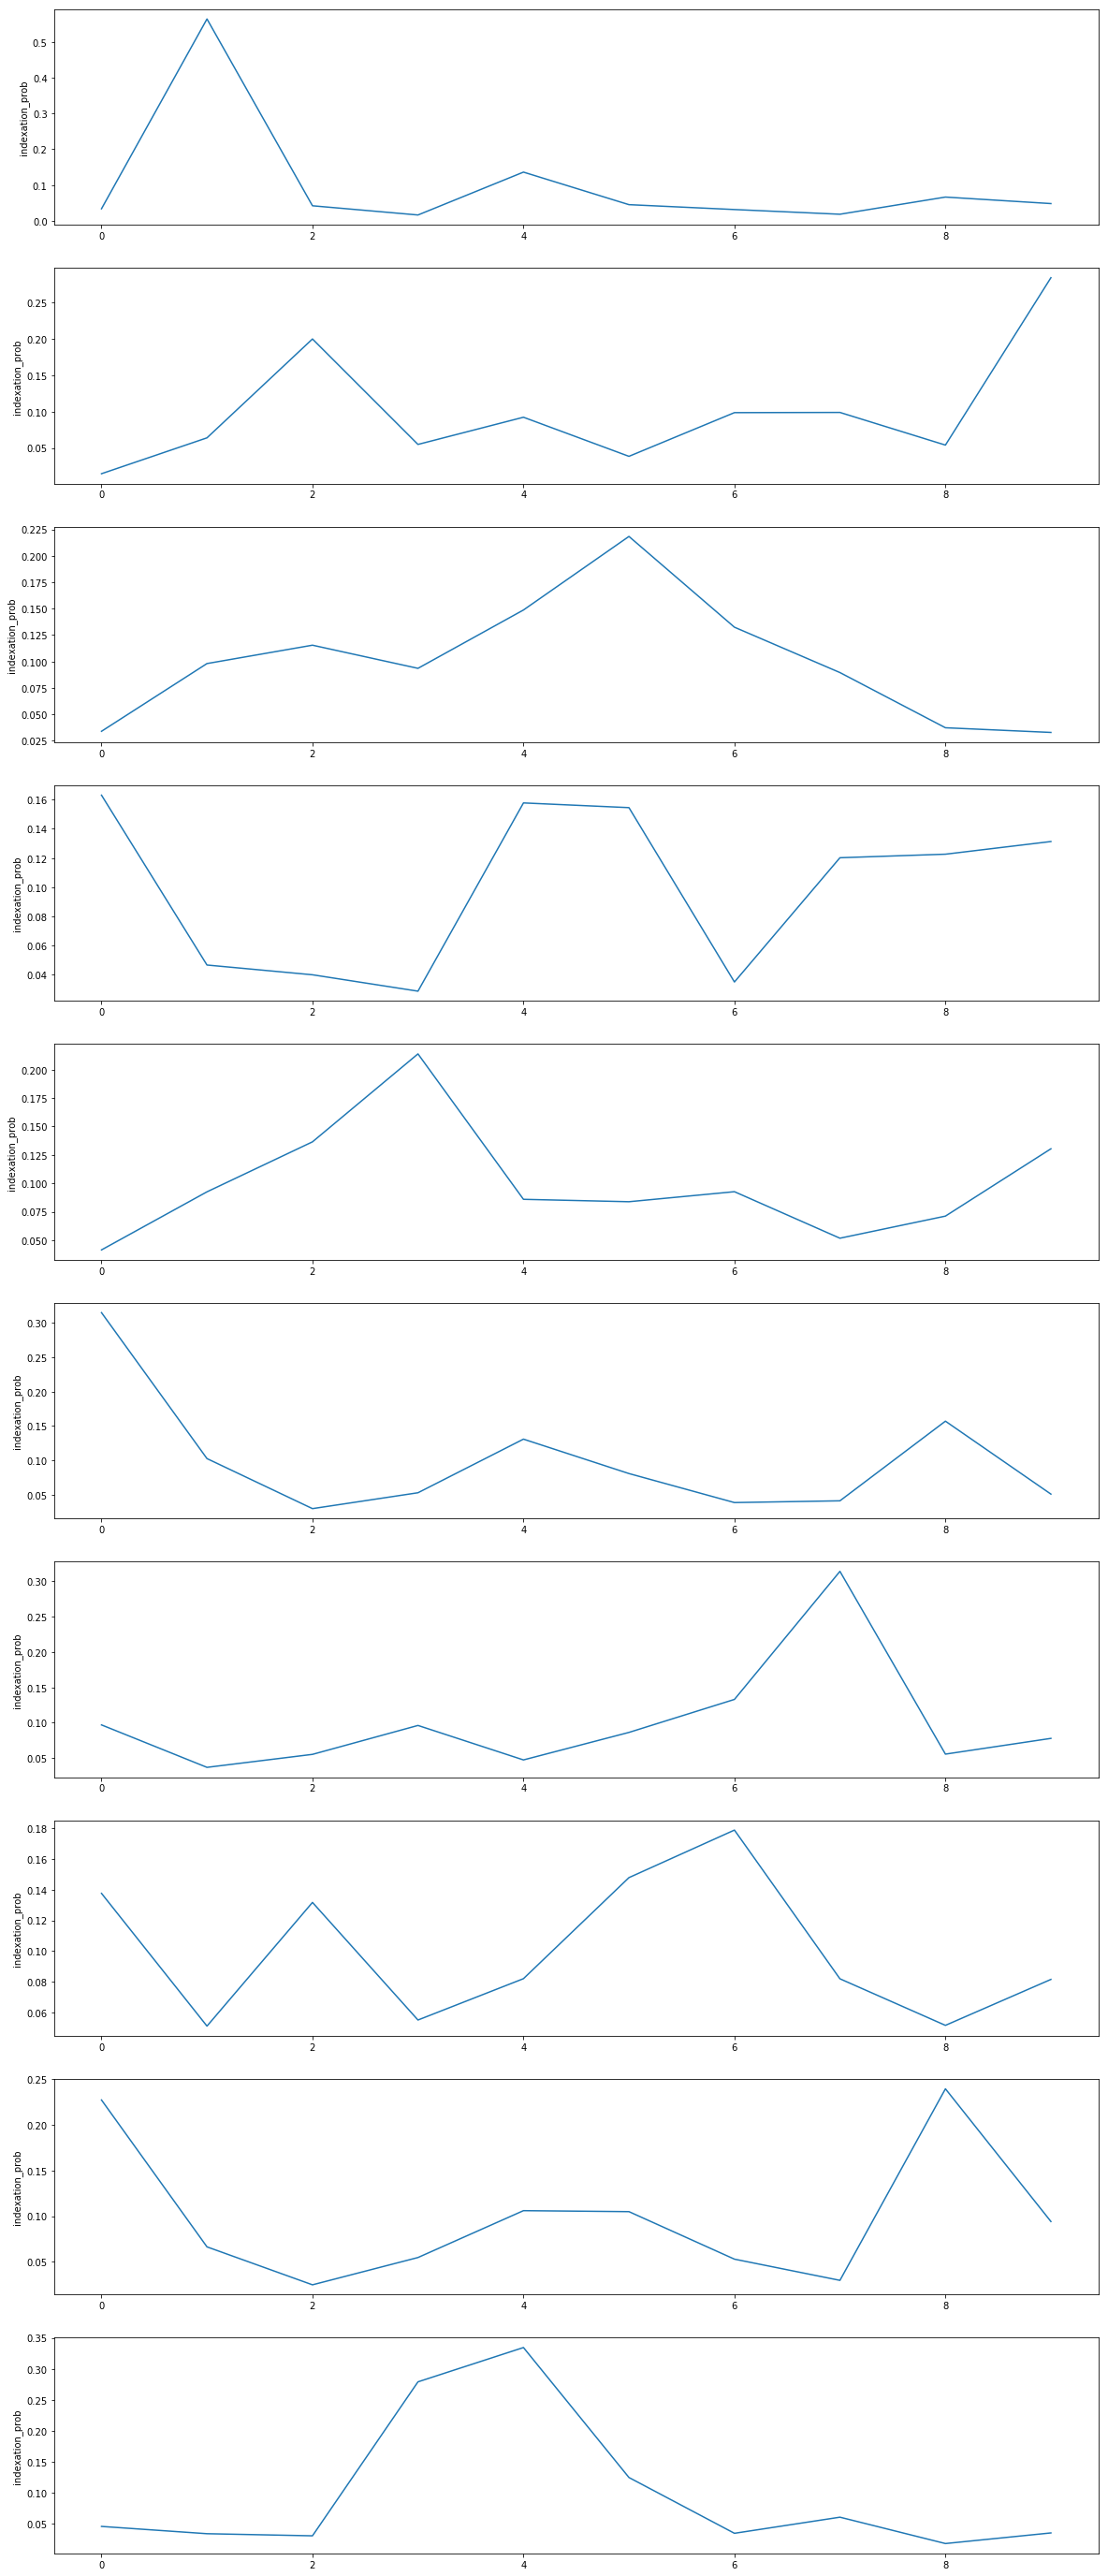

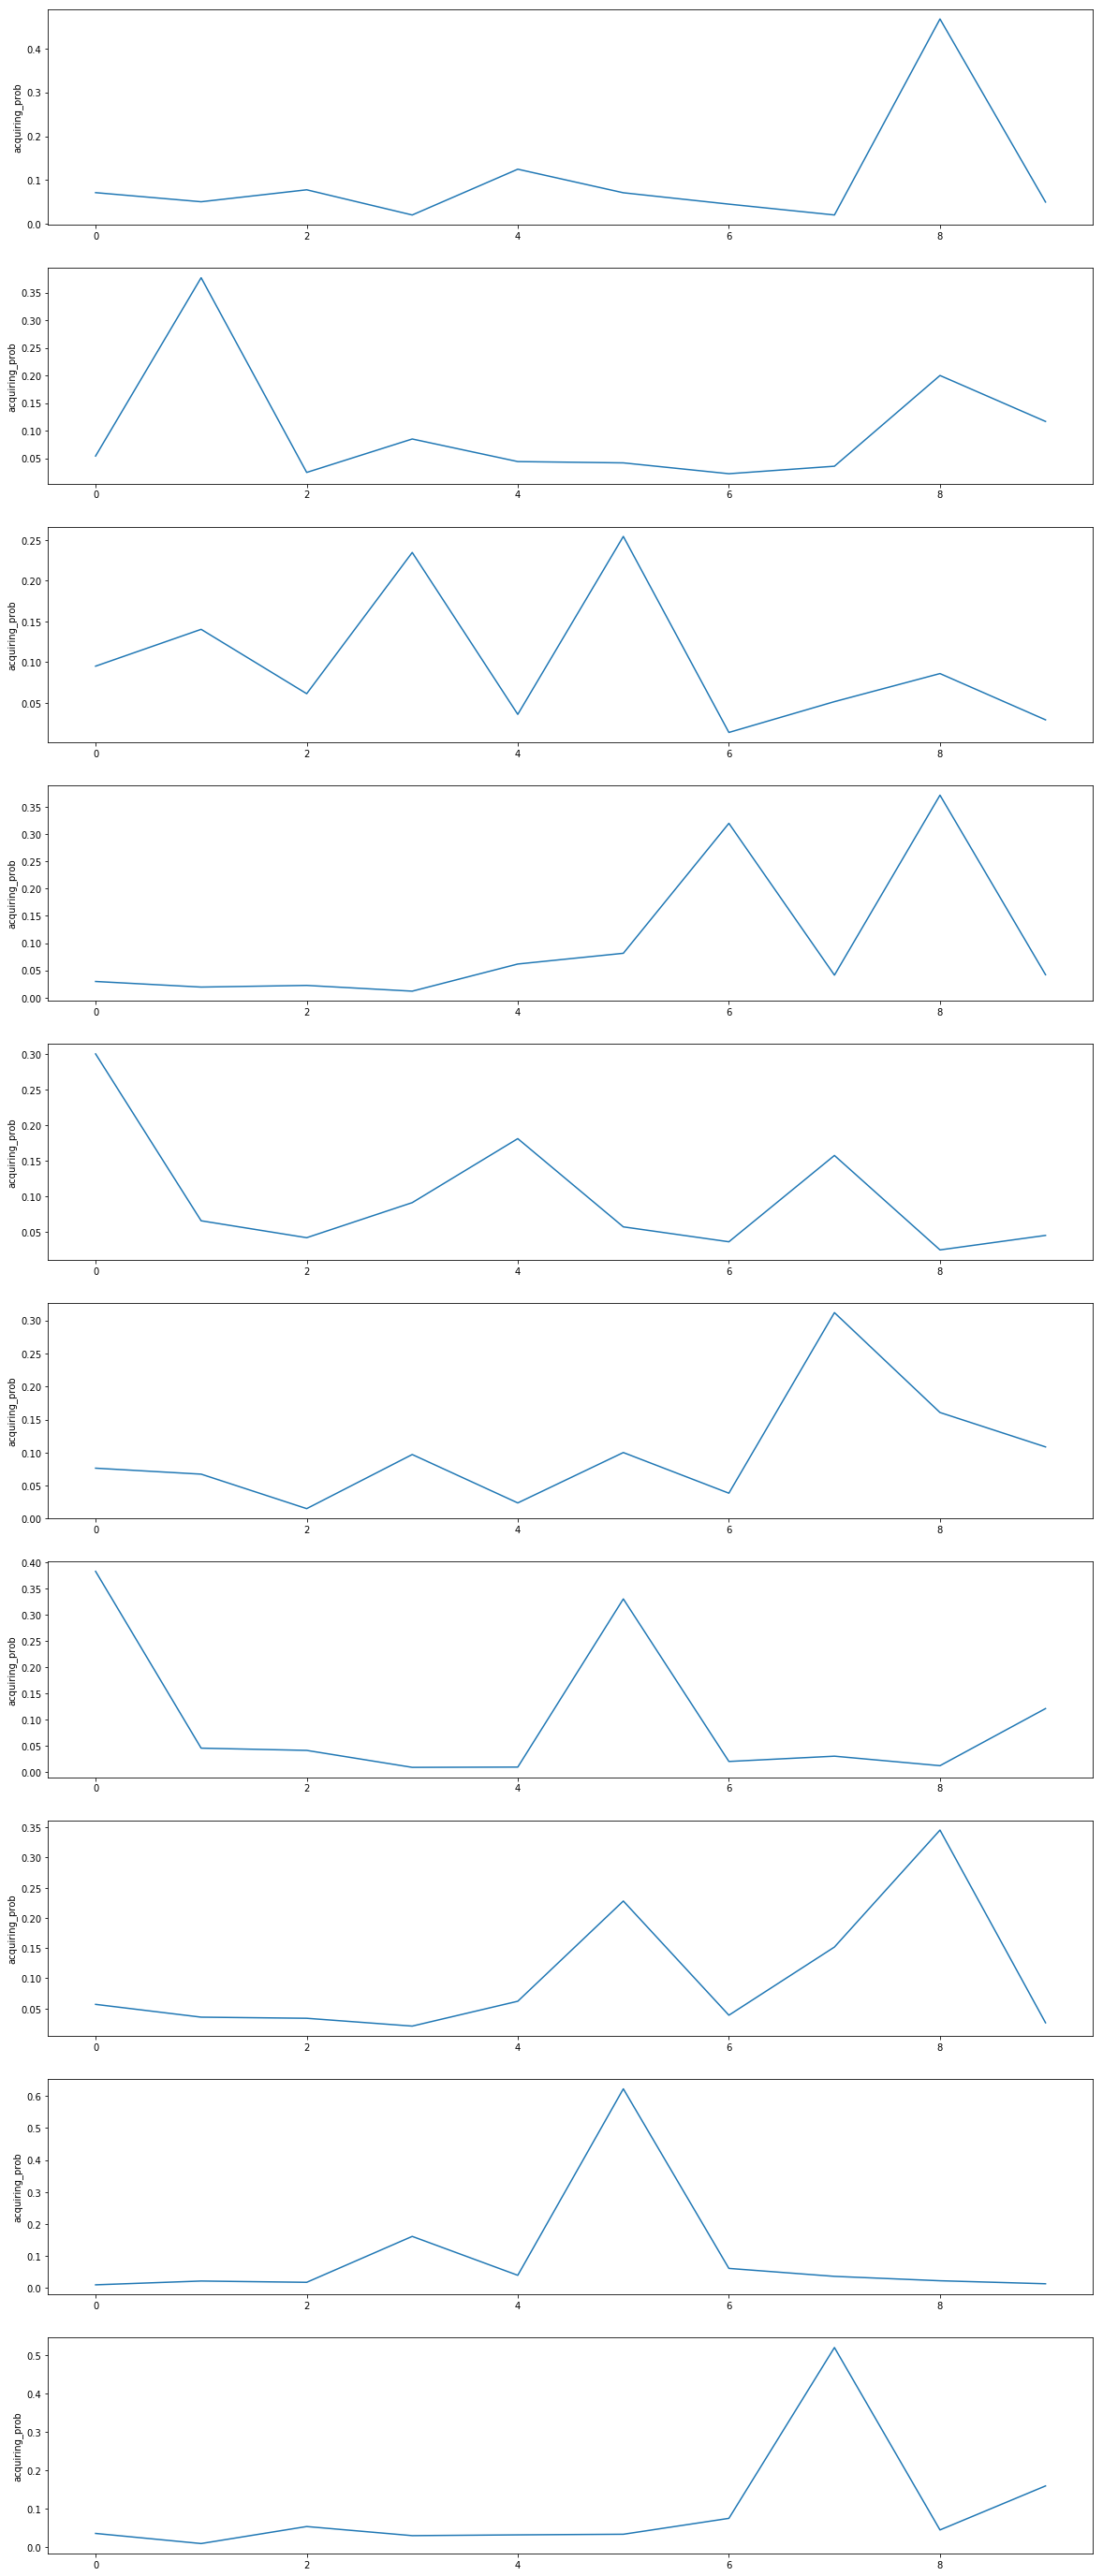

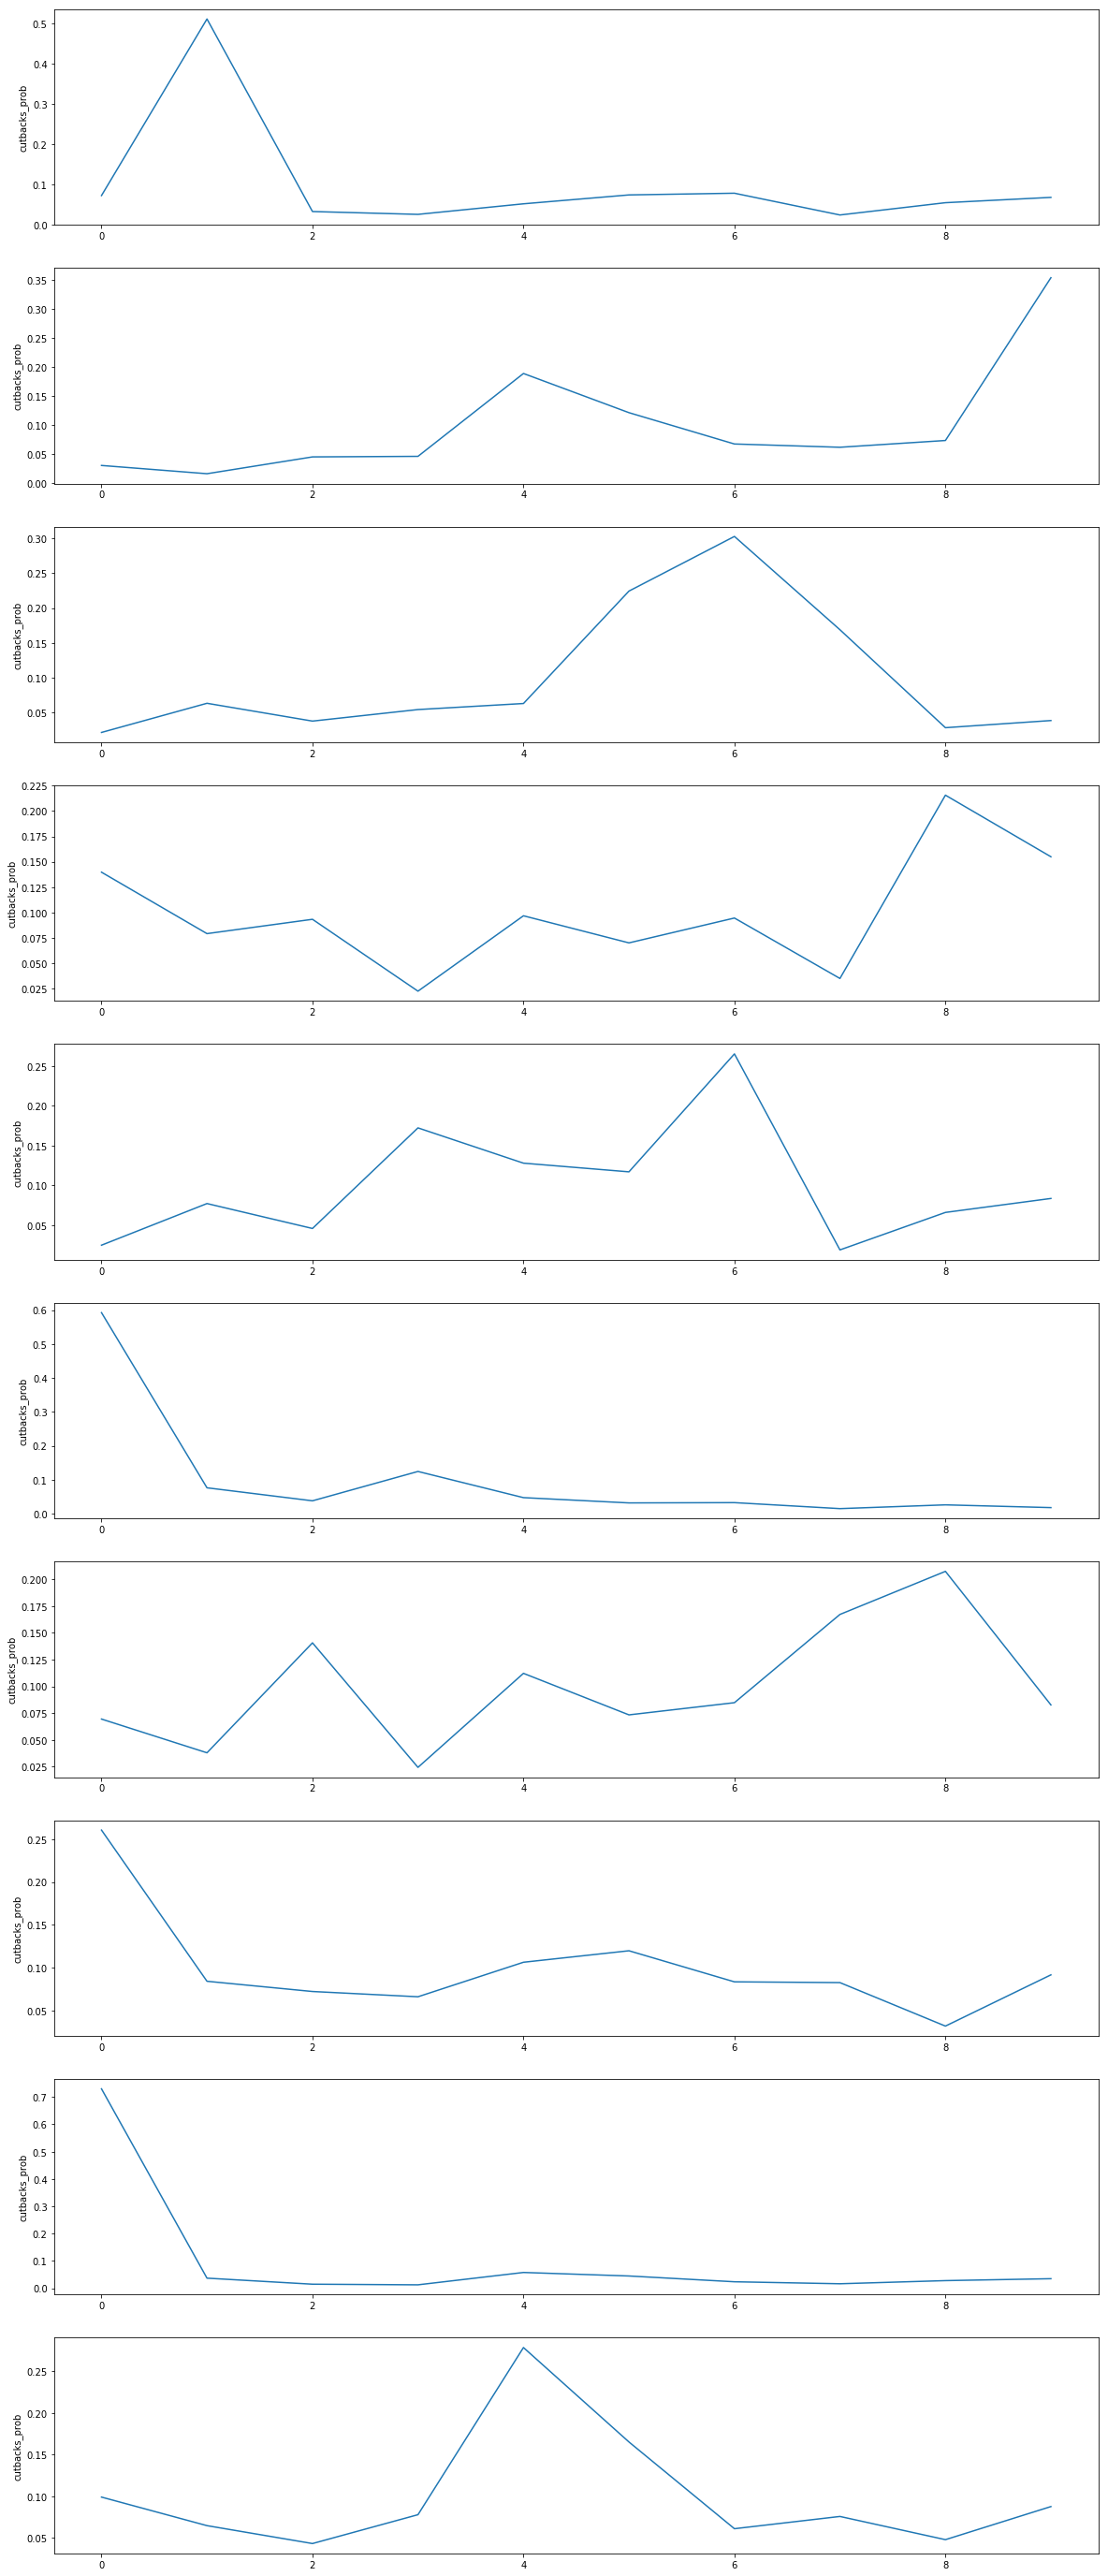

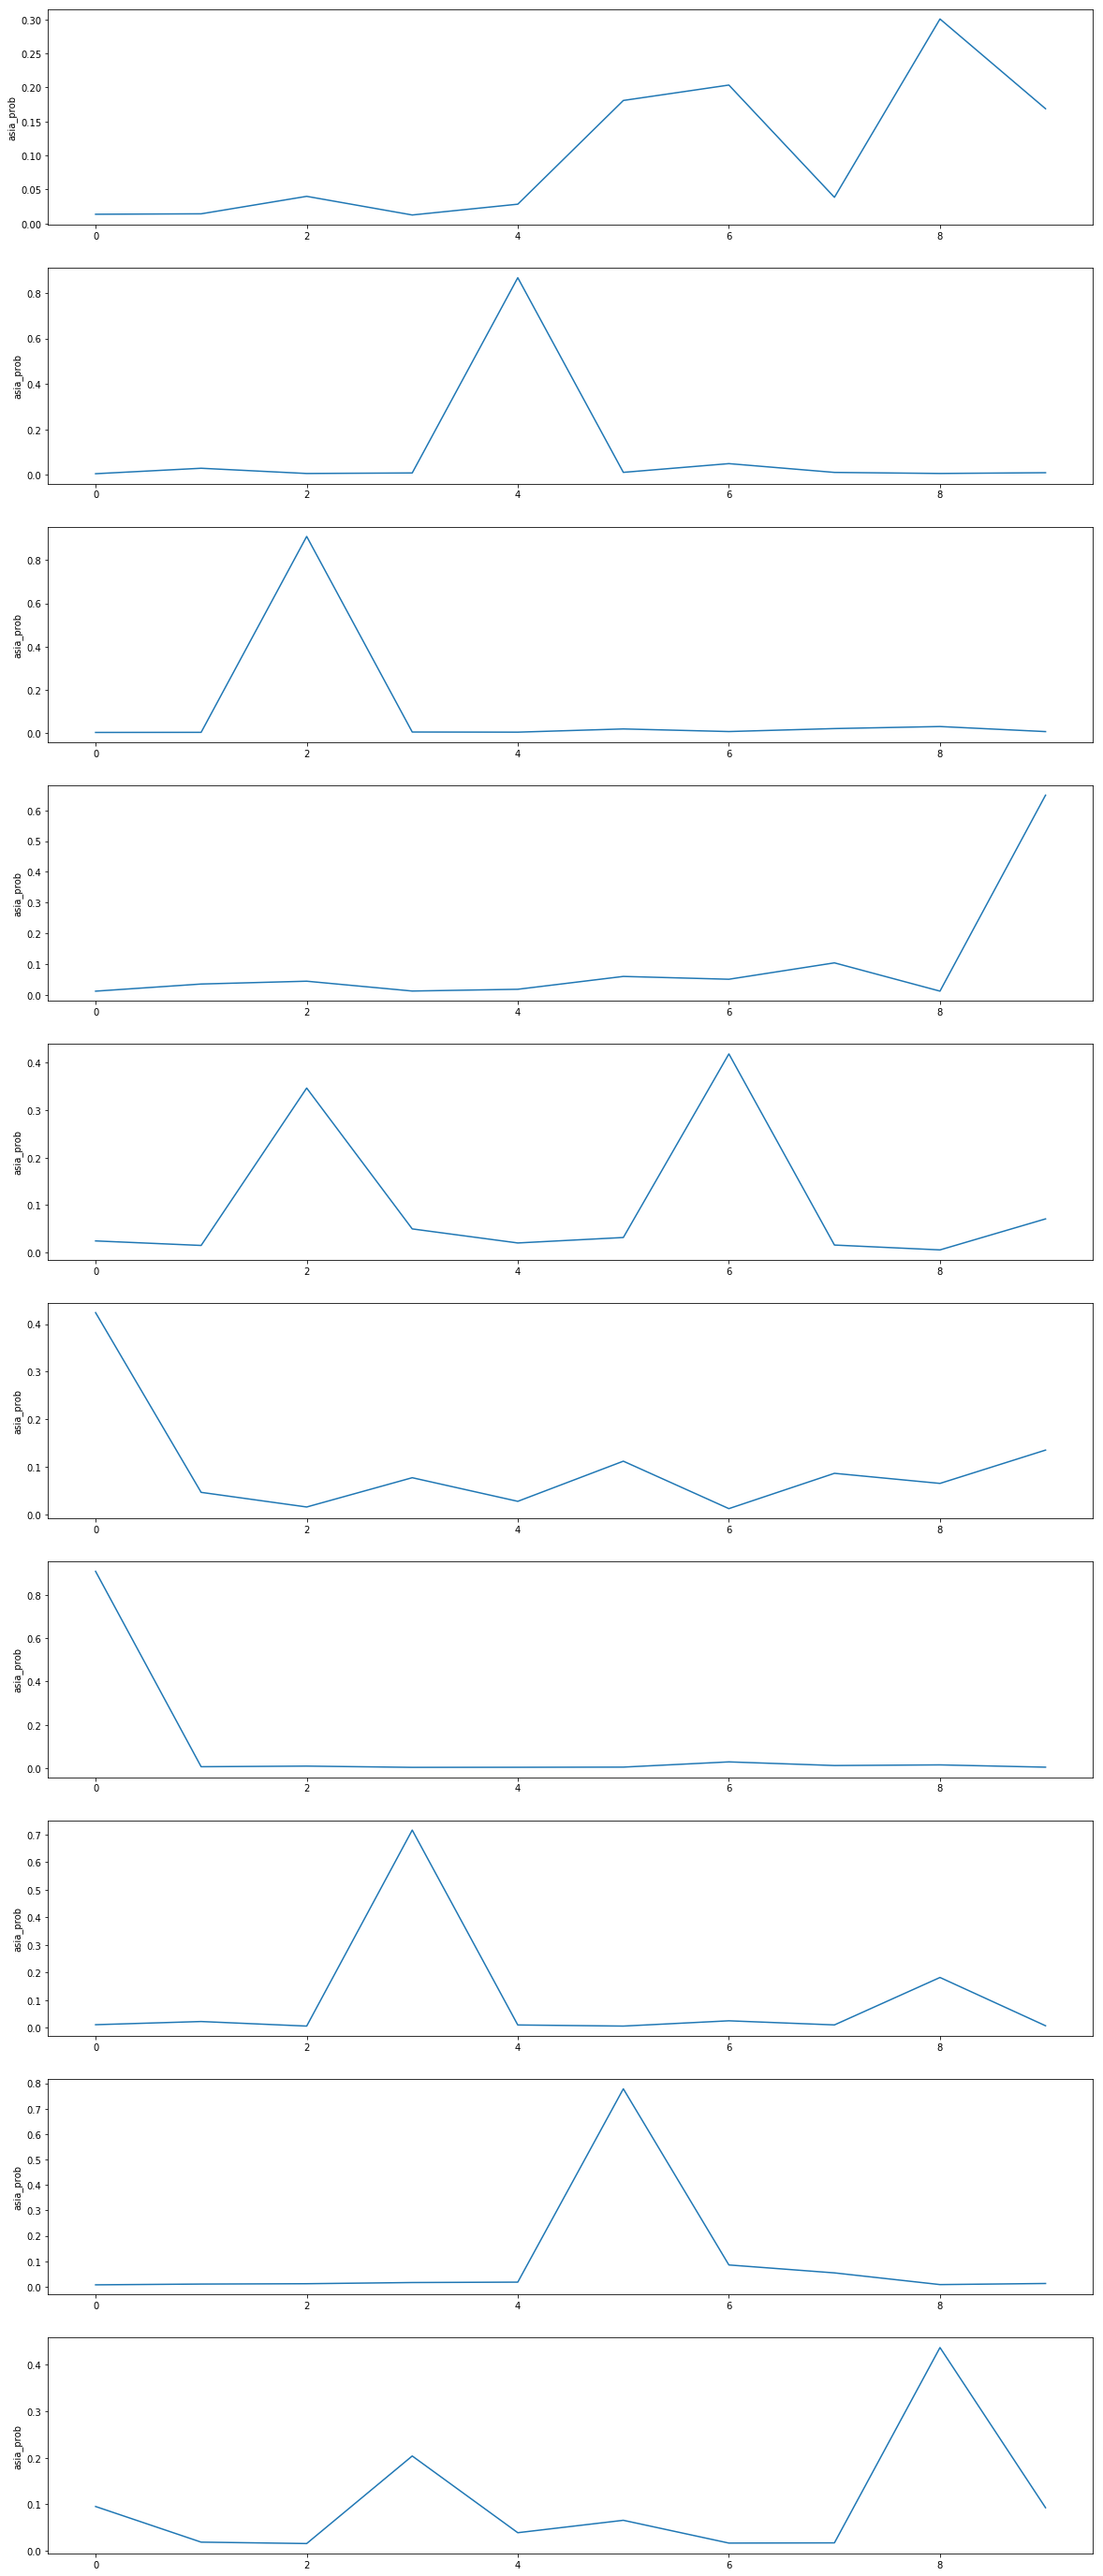

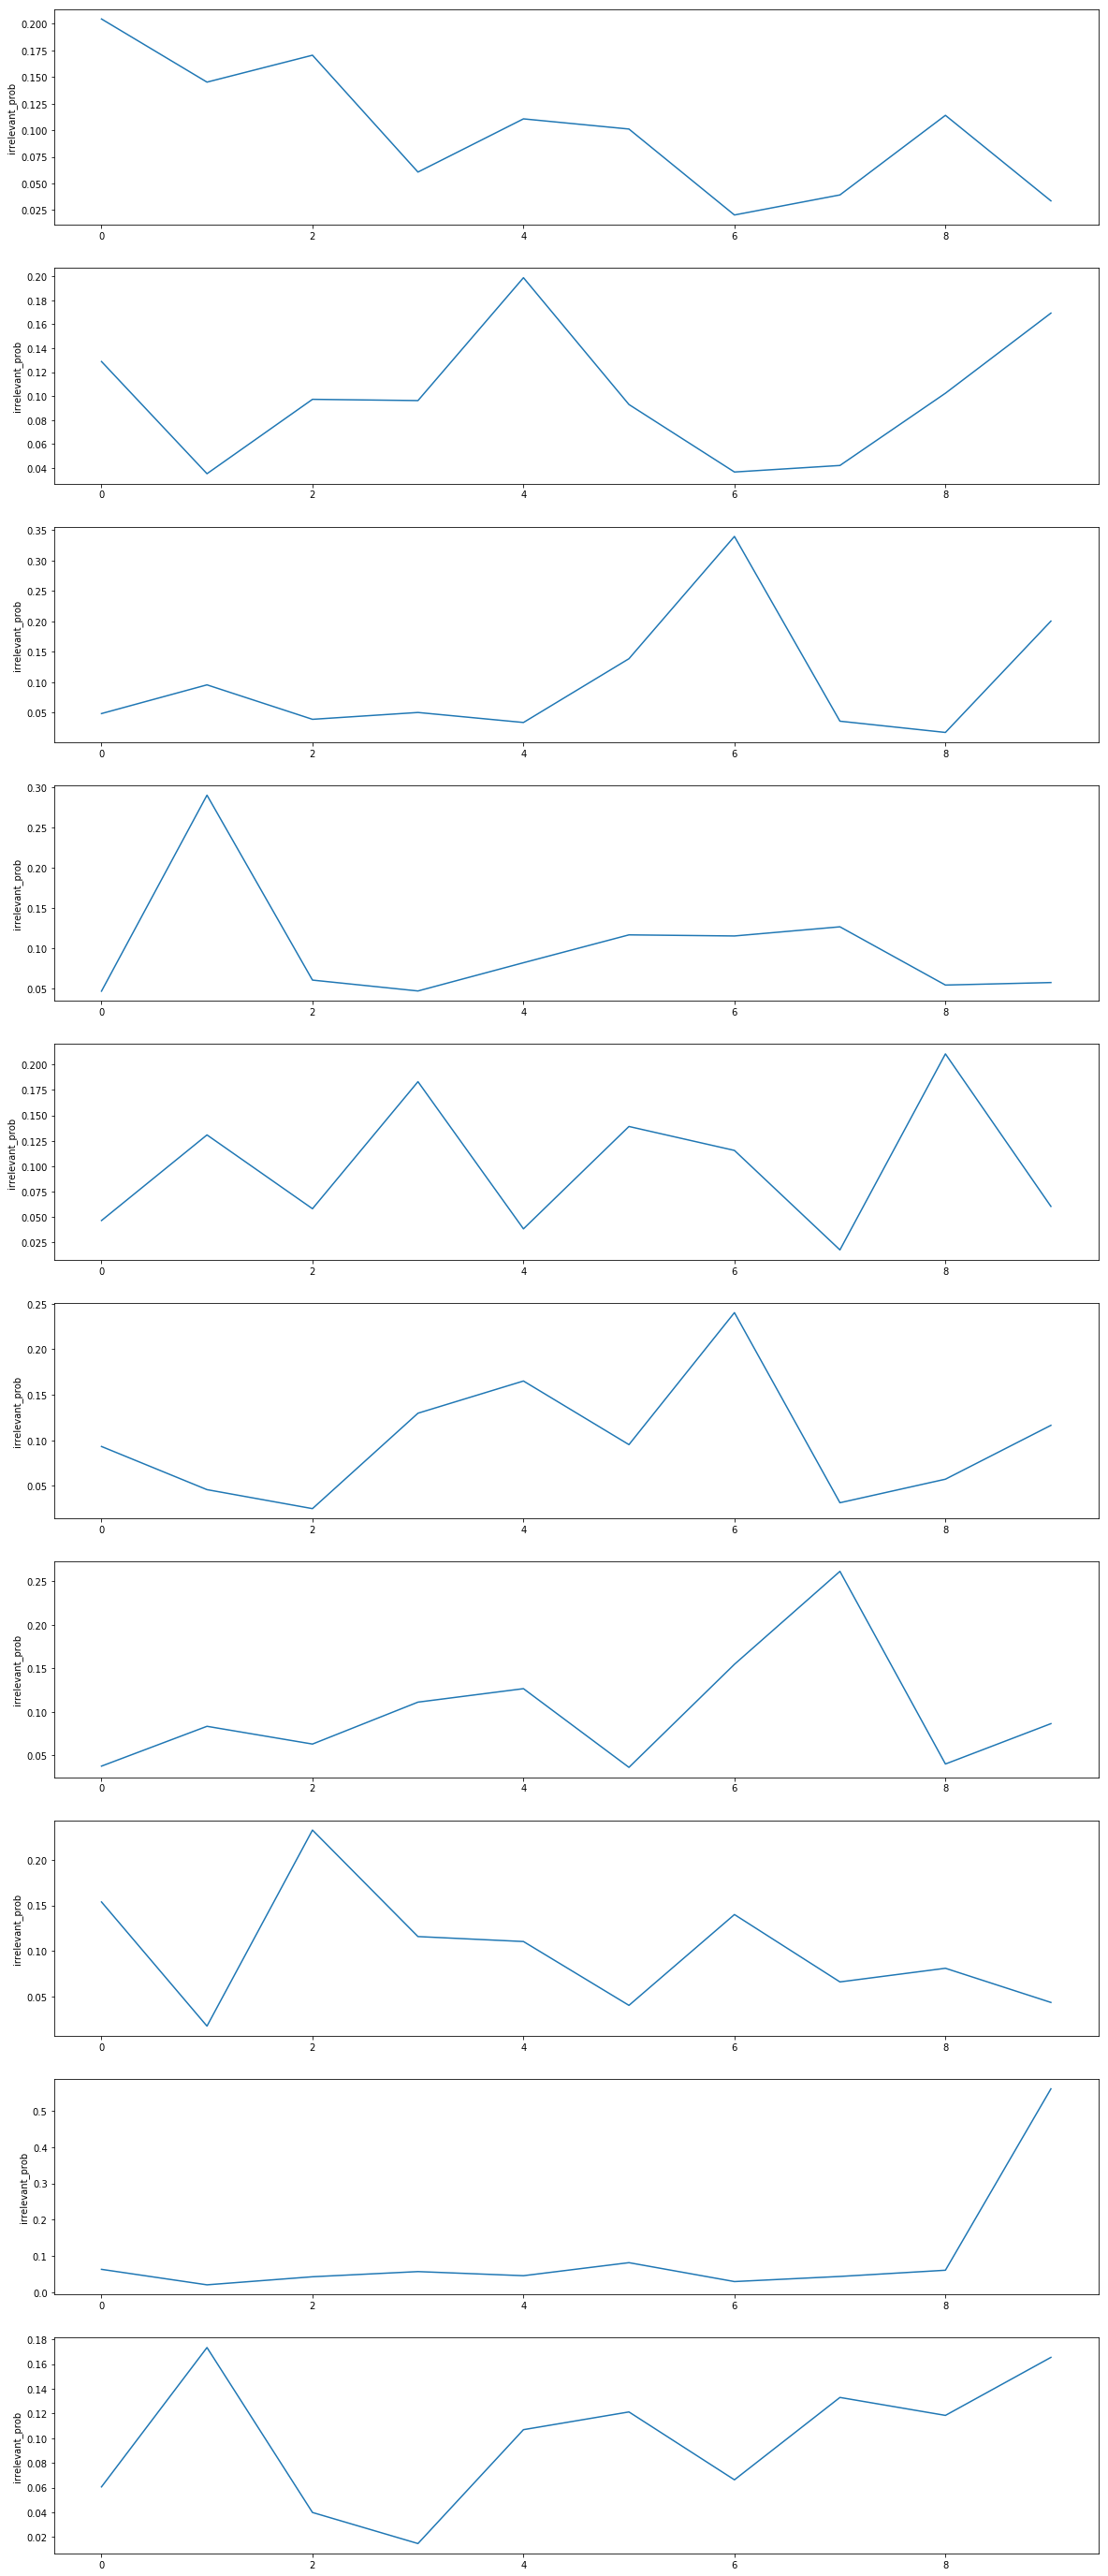

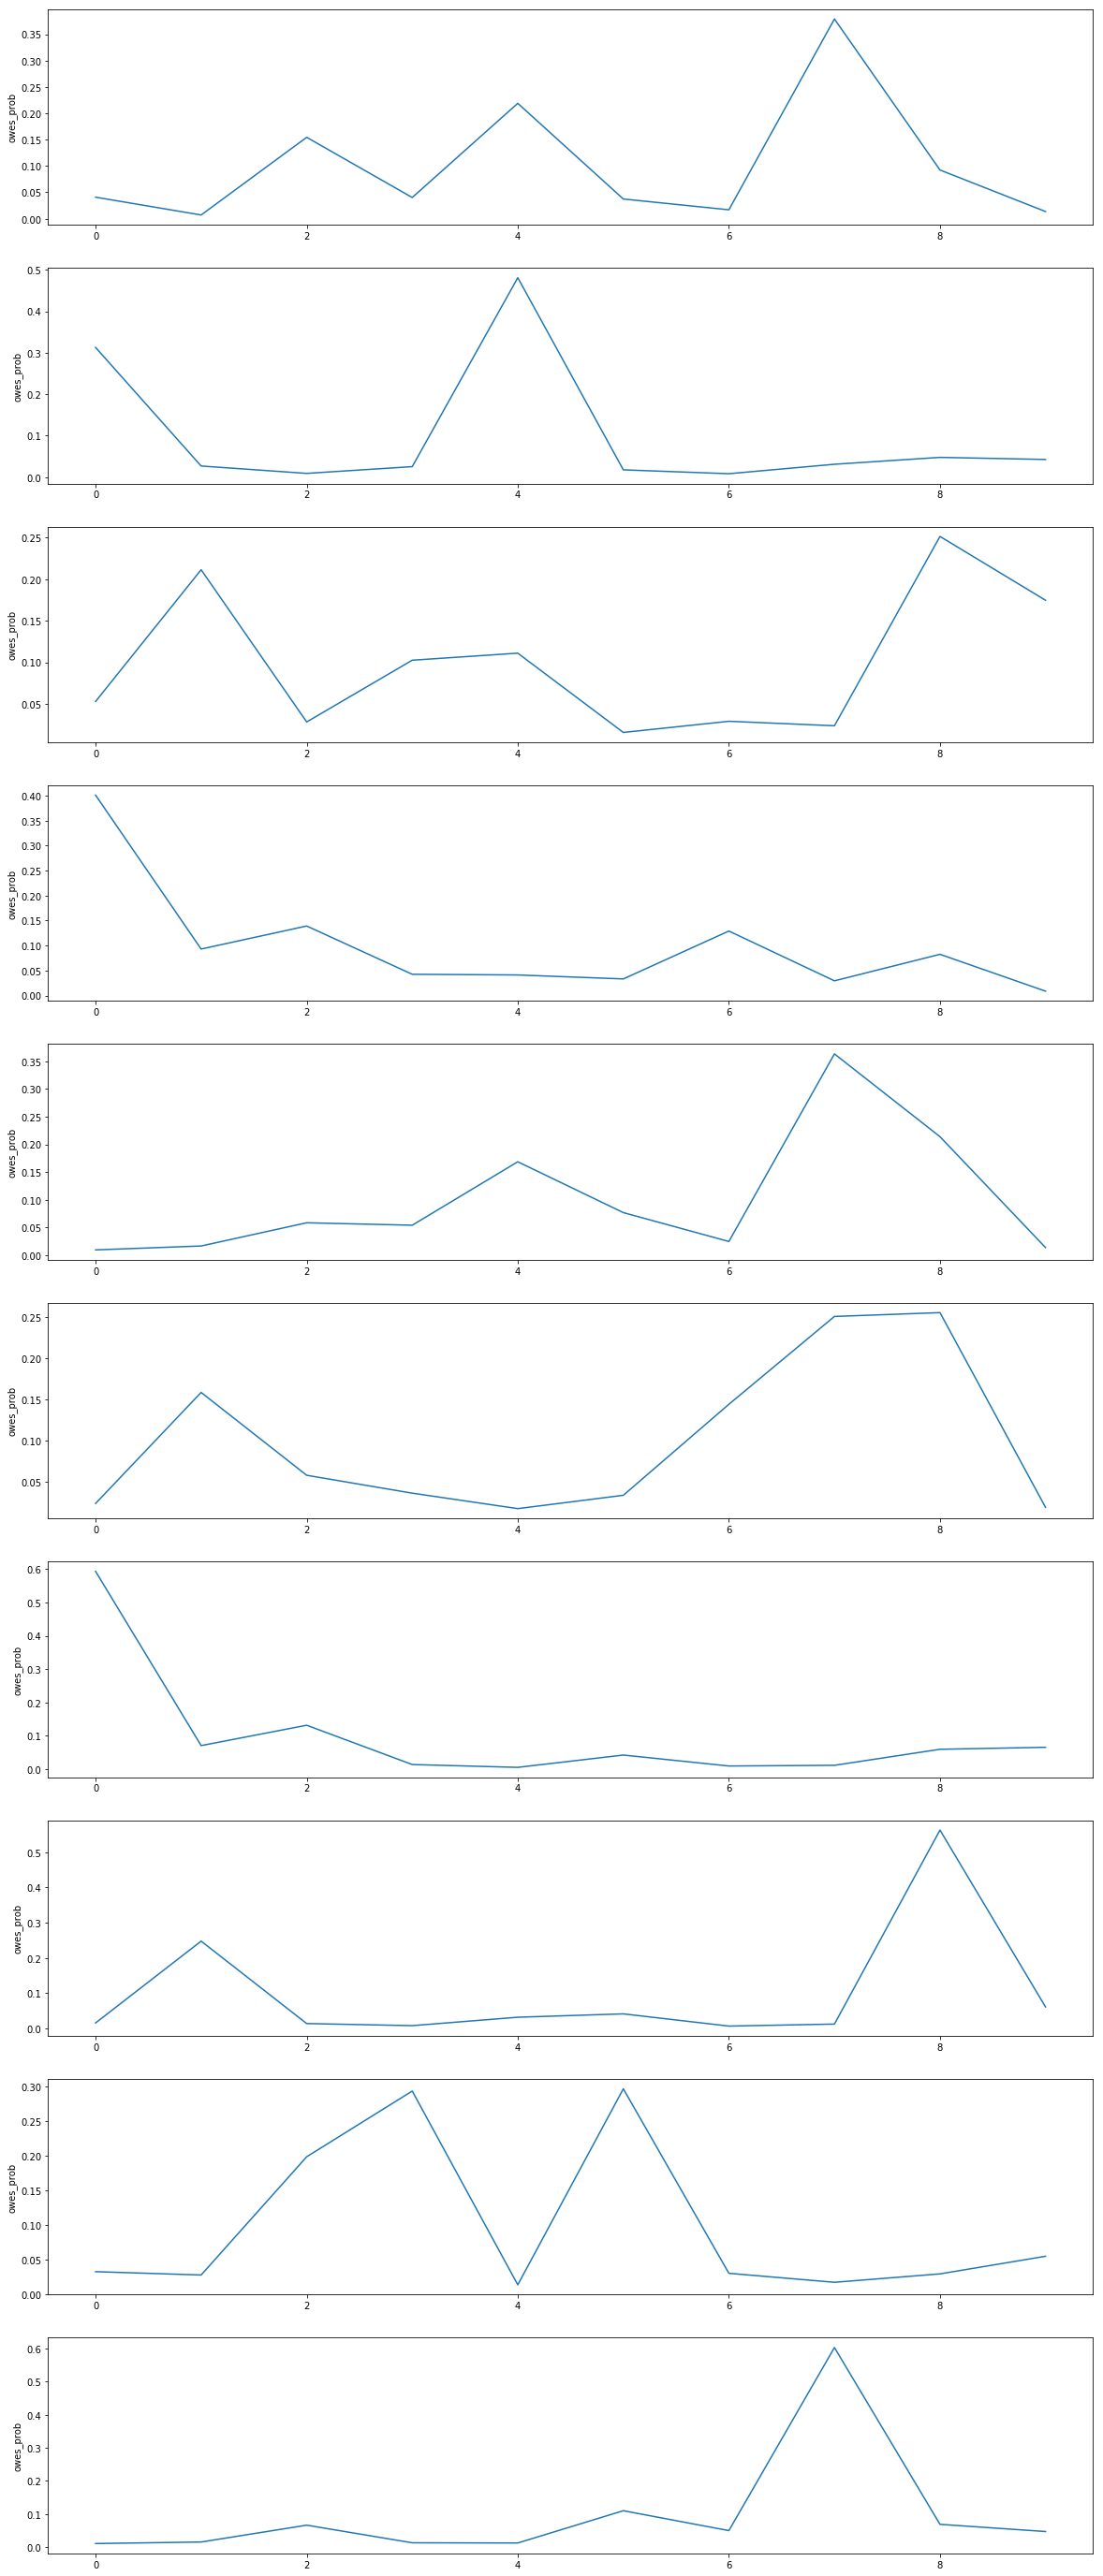

In [192]:
print(np_logit_prob.shape)
for i in np.random.permutation(vocab.size())[:10]:
    #print(i, vocab.decode(i))
    tfig, taxarr = plt.subplots(N, 1)
    tfig.set_size_inches((20,5 * N))
    if N == 1:
        taxarr.plot(np_logit_prob[i][j])
        taxarr.set_ylabel('{}_prob'.format(vocab.decode(i)))
        continue
    for j in range(N):
        taxarr[j].plot(np_logit_prob[i][j])
        taxarr[j].set_ylabel('{}_prob'.format(vocab.decode(i)))
    #print(np_logit_prob[i])
    #input()

## 7. Excel Filling

In [30]:
def visualize(filename, word_alloc, lens):
    result = np.full(lens, '', dtype=object)
    for w in word_alloc:
        result[word_alloc[w]] += ' ' + w
    pd.DataFrame(result).to_csv(filename + '.csv')

In [34]:
np_logit_emb = logit_emb.eval(sess)
np_logit_pos = np.argmax(np_logit_emb.reshape(vocab.size(), N, K), axis=2)
word_alloc = dict((vocab.decode(i), tuple(np_logit_pos[i])) for i in range(vocab.size()))
visualize('w2v_vae/vae', word_alloc, [K] * N)

## 8. Generation

In [161]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [162]:
x_p=p_x.mean()
np_x= sess.run(x_p,{y:np_y})
# generated samples processing
np_x = np_x.argsort(axis=1)
np_x = np_x[:, -10:]
np_x_word = [vocab.decode(np_x[i].tolist()) for i in range(np_x.shape[0])]
_ = [print(s.tolist()) for s in np_x]
_ = [print(s) for s in np_x_word]

[8509, 6193, 8257, 7233, 7949, 9644, 9228, 6277, 7974, 8883]
[7050, 8054, 4986, 1568, 4238, 8569, 5094, 8920, 8103, 9223]
[8380, 9969, 4366, 7193, 9746, 6598, 9965, 8984, 6819, 9964]
[1921, 8837, 8283, 9505, 7384, 9741, 8123, 8428, 9721, 9821]
[9881, 1632, 3049, 9117, 7446, 4955, 7730, 8630, 6544, 9916]
[8492, 992, 7595, 3773, 7650, 7706, 6635, 6213, 7707, 5654]
[6700, 5774, 6734, 8823, 7857, 5802, 5891, 9950, 6840, 4605]
[8689, 4612, 8845, 6144, 7282, 3756, 9174, 8223, 3320, 9353]
[9603, 9708, 8287, 7244, 8907, 3355, 9771, 5972, 6583, 9385]
[8807, 4336, 8947, 5600, 6804, 6349, 8685, 9168, 9679, 7423]
[7460, 6543, 691, 1995, 8025, 5682, 9249, 4350, 9958, 9957]
[8156, 5914, 5553, 9147, 5028, 4329, 8154, 7135, 7569, 8912]
[7883, 546, 9279, 5942, 9247, 8184, 3853, 5479, 6758, 6378]
[9295, 8780, 7781, 7852, 7811, 8210, 9543, 8876, 7879, 7423]
[7898, 6609, 6819, 7292, 9284, 6547, 510, 9125, 8942, 9784]
[3996, 7424, 7433, 8919, 3521, 1686, 373, 6627, 4293, 2314]
[2931, 3387, 9775, 6052, 9607

## 9. Visualize the Embedding

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
    
# Plot
final_embeddings = sess.run(normalized_emb)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = np.random.permutation(vocab.size())[:500]
low_dim_embs = tsne.fit_transform(final_embeddings[plot_only])
labels = [vocab.decode(i) for i in plot_only]
plot_with_labels(low_dim_embs, labels)